# Librerias

In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline



# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

# Configuraciones

In [2]:
path = '/home/marchelo/MarcheloBragagnini/chambas/MLE/MLE_Challenge-20220201T160554Z-001/MLE_Challenge/dataset_for_train'
fileName = 'dataset_credit_risk.csv'

In [3]:
MAX_MEMORY = '15G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 1000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)

In [4]:
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
# Load the main data set into pyspark data frame 

df = spark.read \
        .option('inferSchema', True) \
        .option('header', True) \
        .csv(os.path.join(path, fileName), mode="DROPMALFORMED")
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


# Overview of DataSet

In [5]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- loan_id: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- code_gender: string (nullable = true)
 |-- flag_own_car: string (nullable = true)
 |-- flag_own_realty: string (nullable = true)
 |-- cnt_children: integer (nullable = true)
 |-- amt_income_total: double (nullable = true)
 |-- name_income_type: string (nullable = true)
 |-- name_education_type: string (nullable = true)
 |-- name_family_status: string (nullable = true)
 |-- name_housing_type: string (nullable = true)
 |-- days_birth: integer (nullable = true)
 |-- days_employed: integer (nullable = true)
 |-- flag_mobil: integer (nullable = true)
 |-- flag_work_phone: integer (nullable = true)
 |-- flag_phone: integer (nullable = true)
 |-- flag_email: integer (nullable = true)
 |-- occupation_type: string (nullable = true)
 |-- cnt_fam_members: double (nullable = true)
 |-- status: integer (nullable = true)
 |-- birthday: timestamp (nullable = true)
 |-- job_start_date: timestamp (nullabl

,Column Name,Data type
0,loan_id,int
1,id,int
2,code_gender,string
3,flag_own_car,string
4,flag_own_realty,string
5,cnt_children,int
6,amt_income_total,double
7,name_income_type,string
8,name_education_type,string
9,name_family_status,string


In [6]:
print('Data frame describe (string and numeric columns only):')
df.describe().toPandas()

print(f'There are total {df.count()} row, Let print first 2 data rows:')
df.limit(2).toPandas()

Data frame describe (string and numeric columns only):


,summary,loan_id,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,...,days_birth,days_employed,flag_mobil,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members,status,loan_amount
0,count,777715,777715,777715,777715,777715,777715,777715,777715,777715,...,777715,777715,777715,777715,777715,777715,537667,777715,777715,777715
1,mean,389857.0,5078742.947329034,None,None,None,0.4280822666400931,188534.80207402454,None,None,...,-16124.937046347311,57775.82501559054,1.0,0.23181756813228496,0.3009650064612358,0.09167497090836617,None,2.20883742759237,0.01488334415563542,129.52612050217581
2,stddev,224507.12663892593,41804.42481666427,None,None,None,0.7457552049761571,101622.45007656733,None,None,...,4104.304018129676,136471.73539100477,0.0,0.4219933793484893,0.45867781924167333,0.2885667646982013,None,0.9073797235708048,0.12108612255271367,33.81369876945688
3,min,1000,5008804,F,N,N,0,27000.0,Commercial associate,Academic degree,...,-25152,-15713,1,0,0,0,Accountants,1.0,0,100.0000448717986
4,max,778714,5150487,M,Y,Y,19,1575000.0,Working,Secondary / secondary special,...,-7489,365243,1,1,1,1,Waiters/barmen staff,20.0,1,819.8725813152597


There are total 777715 row, Let print first 2 data rows:


,loan_id,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,...,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members,status,birthday,job_start_date,loan_date,loan_amount
0,208089,5044500,F,N,Y,0,45000.0,Pensioner,Secondary / secondary special,Widow,...,0,0,0,None,1.0,0,1955-08-04,3021-09-18 00:00:00,2019-01-01,133.714974
1,112797,5026631,F,N,Y,0,99000.0,Working,Secondary / secondary special,Separated,...,0,0,0,Medicine staff,1.0,0,1972-03-30,1997-06-05 00:00:00,2019-01-01,158.800558


# Detect missing values and abnormal zeroes

After having a first sight of the columns, the first thing we should check is if the data set having any missing value.
- For string columns, we check for None and null
- For numeric columns, we check for zeroes and NaN
- For array type columns, we check if the array contain zeroes or NaN

In [7]:
print('Columns overview')
dfColumnNameDataType = pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])
dfColumnNameDataType

Columns overview


,Column Name,Data type
0,loan_id,int
1,id,int
2,code_gender,string
3,flag_own_car,string
4,flag_own_realty,string
5,cnt_children,int
6,amt_income_total,double
7,name_income_type,string
8,name_education_type,string
9,name_family_status,string


In [8]:
valColDaType = dfColumnNameDataType.values.tolist()
stringColumns, numericColumns, dateColumns = [],[],[] 
for a,b in valColDaType:
    if b == 'int' or b == 'double':
        numericColumns.append(a)
    elif b == 'string':
        stringColumns.append(a)
    elif b == 'timestamp':
        dateColumns.append(a)

print(f'numeric columns: {numericColumns}')
print(f'string columns: {stringColumns}')
print(f'date columns: {dateColumns}')

numeric columns: ['loan_id', 'id', 'cnt_children', 'amt_income_total', 'days_birth', 'days_employed', 'flag_mobil', 'flag_work_phone', 'flag_phone', 'flag_email', 'cnt_fam_members', 'status', 'loan_amount']
string columns: ['code_gender', 'flag_own_car', 'flag_own_realty', 'name_income_type', 'name_education_type', 'name_family_status', 'name_housing_type', 'occupation_type']
date columns: ['birthday', 'job_start_date', 'loan_date']


In [9]:
missing_values = {} 
for index, column in enumerate(df.columns):
    
    if column in stringColumns:    
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
        
    if column in dateColumns:
        missing_count = df.where(col(column).isin([None])).count()
        missing_values.update({column:missing_count})
        
    if column in numericColumns:
        missing_count = df.where(col(column).isin([None,np.nan])).count()
        missing_values.update({column:missing_count})

        
missing_df = pd.DataFrame.from_dict([missing_values])

In [10]:
missing_df.T.rename(index=str,columns={0:'number of missing values'})

,number of missing values
loan_id,0
id,0
code_gender,0
flag_own_car,0
flag_own_realty,0
cnt_children,0
amt_income_total,0
name_income_type,0
name_education_type,0
name_family_status,0


In [11]:
for column in missing_values:    
    if missing_values[column] != 0:
        if column in stringColumns:
            print("Column")
            df = df.na.fill(value='No Determinado', subset=[column])
            
        if column in dateColumns:
            df = df.na.fill(-100, [column])

        if column in numericColumns:
            d = datetime.datetime(1900,5,16)
            df = df.na.fill(d, [column])

Column


In [12]:
missing_values = {} 
for index, column in enumerate(df.columns):
    
    if column in stringColumns:    
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
        
    if column in dateColumns:
        missing_count = df.where(col(column).isin([None])).count()
        missing_values.update({column:missing_count})
        
    if column in numericColumns:
        missing_count = df.where(col(column).isin([None,np.nan])).count()
        missing_values.update({column:missing_count})

        
missing_df = pd.DataFrame.from_dict([missing_values])
missing_df.T.rename(index=str,columns={0:'number of missing values'})

,number of missing values
loan_id,0
id,0
code_gender,0
flag_own_car,0
flag_own_realty,0
cnt_children,0
amt_income_total,0
name_income_type,0
name_education_type,0
name_family_status,0


# Statistics and information 

In [13]:
countLoanId = df.select('loan_id').distinct().count()
print(f'Total of loans: {countLoanId}')

Total of loans: 777715


In [14]:
countId = df.select('id').distinct().count()
print(f'Total of ids: {countId}')

Total of ids: 36457


In [15]:
countNameIncomes = df.select('name_income_type').distinct().count()
nameIncomes = df.select('name_income_type').distinct()
print(f'Total of name income type: {countNameIncomes}')
nameIncomes.show()

Total of name income type: 5
+--------------------+
|    name_income_type|
+--------------------+
|             Student|
|Commercial associate|
|       State servant|
|             Working|
|           Pensioner|
+--------------------+



In [16]:
df = df.withColumn('PerNameIncomeTypeCount', col('loan_amount'))
df1 = df.select('PerNameIncomeTypeCount')
df1.show(10)

sumTemp = df1.agg(functions.sum('PerNameIncomeTypeCount')).toPandas()
print(sumTemp)

formatSumTemp = format(sumTemp['sum(PerNameIncomeTypeCount)'][0],',f')
print(formatSumTemp)

+----------------------+
|PerNameIncomeTypeCount|
+----------------------+
|      133.714973572794|
|    158.80055787554005|
|    203.60848690335118|
|    113.20496431707618|
|     109.3762599318495|
|    151.61106558834447|
|    100.51565261627002|
|    133.44373968615446|
|    100.82986755739937|
|     190.6895747544295|
+----------------------+
only showing top 10 rows

   sum(PerNameIncomeTypeCount)
0                 1.007344e+08
100,734,406.806350


In [17]:
genderIdCount = df.select('code_gender','id').distinct().groupBy('code_gender').count().toPandas()
genderIdCount

,code_gender,count
0,F,24430
1,M,12027


In [18]:
genderActivitiesCount = df.groupBy('code_gender').count().toPandas()
genderActivitiesCount

,code_gender,count
0,F,518851
1,M,258864


In [19]:
genderIdCountSum = df.select('code_gender','loan_amount').distinct().groupBy('code_gender').sum().toPandas()
genderIdCountSum

,code_gender,sum(loan_amount)
0,F,6.717872e+07
1,M,3.355569e+07


In [20]:
listV = genderIdCountSum.values.tolist()
print(listV)
listV[0][1] = format(listV[0][1],',f')
listV[1][1] = format(listV[1][1],',f')
listV


[['F', 67178718.75219117], ['M', 33555688.05415824]]


[['F', '67,178,718.752191'], ['M', '33,555,688.054158']]

In [21]:
genderGenderLoanFormat = pd.DataFrame(listV,columns=['code_gender','total loan format'])
genderGenderLoanFormat

,code_gender,total loan format
0,F,"67,178,718.752191"
1,M,"33,555,688.054158"


In [22]:
genderIdCountActivities = genderIdCount.join(
        genderActivitiesCount.set_index('code_gender'), on='code_gender'
        , how='inner', lsuffix='_gu')
genderIdCountActivities = genderIdCountActivities.join(
        genderIdCountSum.set_index('code_gender'), on='code_gender',
        how = 'inner', lsuffix='_gu')

genderIdCountActivities = genderIdCountActivities.join(
        genderGenderLoanFormat.set_index('code_gender'), on='code_gender',
        how = 'inner', lsuffix='_gu')


genderIdCountActivities

,code_gender,count_gu,count,sum(loan_amount),total loan format
0,F,24430,518851,6.717872e+07,"67,178,718.752191"
1,M,12027,258864,3.355569e+07,"33,555,688.054158"


In [23]:
# We create new column to count the number of timestamps recorded per row/workout, 
# named as 'PerWorkoutRecordCount' column

df = df.withColumn('PerNameIncomeTypeCount', col('loan_amount'))

# This part is writen as a function to be used again later
def userActivityLoansSummarize(df):
    idCount = format(df.select('id').distinct().count(), ',d')
    loanCount = format(df.select('loan_id').distinct().count(), ',d')    
    activityCount = str(df.select('name_income_type').distinct().count())    
    sumTemp = df.agg(functions.sum('loan_amount')).toPandas()    
    totalLoanAmount = format(sumTemp['sum(loan_amount)'][0],',f')
    
    columns=['ids count', 'Name Income types count','Loans count', 'Total of loan amount']
    data = [[idCount], [activityCount], [loanCount], [totalLoanAmount]]
    
    sumDict = {column: data[i] for i, column in enumerate(columns)}
    sumDf = pd.DataFrame.from_dict(sumDict)[columns]
    
    # total loan amount by gender
    genderIdCount = df.select('code_gender','id').distinct().groupBy('code_gender').count().toPandas()
    genderActivitiesCount = df.groupBy('code_gender').count().toPandas()
    genderIdCountSum = df.select('code_gender','loan_amount').distinct().groupBy('code_gender').sum().toPandas()
    listV = genderIdCountSum.values.tolist()
    for i in range(0,len(listV[0])):
        listV[i][1] = format(listV[i][1],',f')
    genderGenderLoanFormat = pd.DataFrame(listV,columns=['code_gender','total loan format'])    
    genderIdCountActivities = genderIdCount.join(
            genderActivitiesCount.set_index('code_gender'), on='code_gender'
            , how='inner', lsuffix='_gu')
    genderIdCountActivitiesLoans = genderIdCountActivities.join(
            genderGenderLoanFormat.set_index('code_gender'), on='code_gender',
            how = 'inner', lsuffix='_gu')
    genderIdCountActivitiesLoans.columns = ['Gender', '# of id', 'Count', 'Total loans']
    
    return sumDf, genderIdCountActivitiesLoans

sumDfs= userActivityLoansSummarize(df)

In [24]:
print('\nOverall data set summary on id, activities and number of loanIds (pre-filtering):')
sumDfs[0]


Overall data set summary on id, activities and number of loanIds (pre-filtering):


,ids count,Name Income types count,Loans count,Total of loan amount
0,"36,457",5,"777,715","100,734,406.806350"


In [25]:
print('\nOverall data set summary on gender, activities and number of loanIds (pre-filtering):')
sumDfs[1]


Overall data set summary on gender, activities and number of loanIds (pre-filtering):


,Gender,# of id,Count,Total loans
0,F,24430,518851,"67,178,718.752191"
1,M,12027,258864,"33,555,688.054158"


In [26]:
print('\nOverall data set summary on id, total loan amount by ids')
dfTotalAmountLoanById = df.select('id','loan_amount').groupBy('id').sum('loan_amount').toPandas()
dfTotalAmountLoanById.rename(columns={'id':'id', 'sum(loan_amount)': 'total_loan_amount'}, inplace=True)
dfTotalAmountLoanById


Overall data set summary on id, total loan amount by ids


,id,total_loan_amount
0,5126729,3379.961416
1,5100303,2389.001024
2,5046384,707.766465
3,5069001,5734.466565
4,5135605,3049.172055
...,...,...
36452,5010608,359.304407
36453,5010766,116.809264
36454,5045631,585.857350
36455,5114593,266.040090


In [27]:
# dfTotalAmountDescribe = dfTotalAmountLoanById['total_loan_amount'].describe().astype(int)
print('Description of total loan amount by Ids')
dfTotalAmountLoanById[['total_loan_amount']].describe().T

Description of total loan amount by Ids


,count,mean,std,min,25%,50%,75%,max
total_loan_amount,36457.0,2763.101923,1937.501762,100.118981,1164.224027,2300.780141,4033.018154,8568.470893


# More Exploratory Data Analysis

# Generic plots & Helpers

In [28]:
def get_dataframe_by_columnX_user_loan(dataframe_sp, nameColumn):
    
    # dataframe columnX and user_ids
    columnX_users_df = dataframe_sp.select(nameColumn, 'id') \
        .distinct() \
        .groupBy(nameColumn) \
        .count() \
        .orderBy("count", ascending=False)
    
    columnX_users_df_pandas = columnX_users_df.toPandas()
    total_users = columnX_users_df.groupBy().sum().collect()[0][0]
#     columnX_users_df_pandas.rename(columns= {'count': f'Users_count ({total_users})'}, inplace=True)
    columnX_users_df_pandas.rename(columns= {'count': f'Users_count'}, inplace=True)

    # dataframe columnX and loans
    columnX_loans_df = dataframe_sp.select(nameColumn, 'loan_id') \
        .distinct() \
        .groupBy(nameColumn) \
        .count() \
        .orderBy("count", ascending=False)
    columnX_loans_df_pandas = columnX_loans_df.toPandas()
    total_loans = columnX_loans_df.groupBy().sum().collect()[0][0]
#     columnX_loans_df_pandas.rename(columns= {'count': f'Loans_count ({total_loans})'}, inplace=True)
    columnX_loans_df_pandas.rename(columns= {'count': f'Loans_count'}, inplace=True)

    # join (dataframe activities and user ids, dataframe activities and loans)
    ranked_columnX_userId_loan_df_pandas = columnX_users_df_pandas.join(
            columnX_loans_df_pandas.set_index(nameColumn),
            on=nameColumn,
            how='inner',
            lsuffix='_gu')
    
    return ranked_columnX_userId_loan_df_pandas, total_users, total_loans

# res = get_dataframe_by_columnX_user_loan(df,'name_income_type')
# ranked_activity_userId_loan_df_pd = res[0]
# total_users = res[1]
# total_loans = res[2]

# print(f'Total de user ids: {total_users}')
# print(f'Total de loans ids: {total_loans}')
# ranked_activity_userId_loan_df_pd

In [29]:
def plot_dataframe_by_columnX_user_loan(dataframe_pd, name_column, total_user_column, total_users):
    print(f'\n Plotting table with percentages')
    dataframe_pd['percentage'] = dataframe_pd[total_user_column] / total_users * 100
    display(dataframe_pd)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

    plot0 =   axs[0].bar(x=dataframe_pd[name_column]
                         , height=dataframe_pd[total_user_column])

    title0 =  axs[0].set_title('Users count', fontsize = 'small')
    xlabel0 = axs[0].set_xlabel(name_column, fontsize = 'small')
    ylabel0 = axs[0].set_ylabel('Users count', fontsize = 'small')
    xsticks_label = axs[0].set_xticklabels(dataframe_pd[name_column]
                                           ,rotation = 'vertical', 
                                           fontsize='small')
    total_class = len(dataframe_pd[name_column].unique())
    print(total_class)
        
    valRat = 0.3 if total_class > 5 else 0.18
    explode = (valRat,) * total_class
    title1 = axs[1].set_title('User ratio', fontsize = 'small')
    plot1 = axs[1].pie(
          x=dataframe_pd['percentage']
        , labels=dataframe_pd[name_column]
        , autopct='%1.1f%%', shadow=True, explode=explode, startangle=90
        , radius=1
    )

    text = fig.text(0.5, 1.02, 'Statitics of activities', ha='center', va='top', transform=fig.transFigure)
    
# plot_dataframe_by_columnX_user_loan(
#     ranked_activity_userId_loan_df_pd, 'name_income_type', 'Users_count', total_users)

In [30]:
def gen_dataframe_biclass_multiclass_vs_loans(dataframe_sp, bi_name_col, multi_name_col):
    multi_by_bi_col = dataframe_sp.groupBy(multi_name_col, bi_name_col).count().toPandas() 
     
    print(f'Overall of {multi_name_col} & {bi_name_col} vs counts loans')
    multi_by_bi_col_pd = multi_by_bi_col.pivot_table(index=multi_name_col, 
                                                               columns=bi_name_col, 
                                                               values='count', 
                                                               fill_value=0) \
                                                .reset_index() \
                                                .rename_axis(None, axis=1)
    last_columns = multi_by_bi_col_pd.columns[-2:]
    multi_by_bi_col_pd['total'] = multi_by_bi_col_pd[last_columns].sum(axis=1) # +multi_by_bi_col_pd.iloc[2]
    multi_by_bi_col_pd.sort_values(by='total', ascending=False, inplace=True)
    return multi_by_bi_col_pd
    
    
# gen_dataframe_biclass_multiclass_vs_loans(df, 'code_gender', 'name_income_type')

In [31]:
# def plot_dataframe_biclass_multiclass(dataframe_sp, dataframe_pd, multi_col, name_multi_col, bi_col, name_bi_col):
def plot_dataframe_biclass_multiclass(dataframe_sp, multi_col, name_multi_col, bi_col, name_bi_col):
    
#     total_multi_column = dataframe_pd[multi_col].count()
#     print(f'There are total: {total_multi_column} {name_multi_col} and here is the chart for {name_multi_col} based on {name_bi_col}:')
    # Add the infor of activities based on gender
    
    print(f'\n Plot {name_multi_col} vs {name_bi_col} for all loans')
    multi_by_bi_loans_pd = dataframe_sp.groupBy(multi_col, bi_col).count().toPandas()
    num_multi_cate = len(multi_by_bi_loans_pd[multi_col].unique())
    
    # Visualize
    fig_num_multi_cate = 8 if num_multi_cate > 10 else 4
    fig = plt.figure(figsize=(12, fig_num_multi_cate))
    grid_size = (1,1);
    ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
    plot = multi_by_bi_loans_pd.groupby([multi_col, bi_col]).agg(np.mean).groupby(level=0).apply(
        lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', stacked=True, width=1  ## APPLY UNSTACK TO RESHAPE DATA
                    , edgecolor='black', ax=ax, title=f'List of all {name_multi_col} by {name_bi_col}')
    ylabel = plt.ylabel(name_multi_col);
    xlabel = plt.xlabel(f'Participation percentage by {name_bi_col}');
    legend = plt.legend(
        sorted(multi_by_bi_loans_pd[bi_col].unique()), loc='center left', bbox_to_anchor=(1.0, 0.5)
    )
    param_update = plt.rcParams.update({'font.size': 16});
    ax = plt.gca()
    formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter());
    a = fig.tight_layout()
    plt.show()
    
    
# plot_dataframe_biclass_multiclass(df,
#                                   'name_income_type', 'type of income',
#                                   'code_gender', 'gender')


In [32]:
def gen_dataframe_biclass_multiclass_vs_userIds(dataframe_sp, bi_col, multi_col):
    df_temp_sp = dataframe_sp.select('id', bi_col, multi_col) \
                    .distinct() \
                    .groupBy('id', bi_col) \
                    .count() 
    df_temp_sp = df_temp_sp.filter(df_temp_sp['count'] > 1) \
                    .orderBy("count", ascending=False) \
                    .toPandas()
    return df_temp_sp

# df_temp_sp = gen_dataframe_biclass_multiclass_vs_userIds(df, 'code_gender', 'name_income_type')
# df_temp_sp.describe().T

In [33]:
def plot_histogram_multi_class(dataframe_sp, multi_col, name_multi_col):
    dataframe_temp = dataframe_sp.select(multi_col, 'id', 'loan_id') \
                                    .groupBy(multi_col, 'id') \
                                    .count() \
                                    .withColumnRenamed(multi_col, name_multi_col) \
                                    .withColumnRenamed('id', 'UserId') \
                                    .withColumnRenamed('count', 'NumLoans')
    dataframe_temp_pd = dataframe_temp.toPandas()
    list_multi_col_values = dataframe_temp_pd[name_multi_col].unique()
    number_multi_class = len(list_multi_col_values)
    
    print(f'List of {name_multi_col} ({number_multi_class})')
    for item in list_multi_col_values:
        print(f'- {item}')
    print(f'\n Plotting distribution of number loans by {name_multi_col}:')
    
    plot_size_x, plot_size_y = 5, 5
    grid_size = (int((number_multi_class+2)/3),3)
    figsize_x, figsize_y = plot_size_x * grid_size[1] +3, plot_size_y * grid_size[0] + 1
    figsize = (figsize_x, figsize_y)
    fig = plt.figure(figsize=figsize) 
    ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)

    duration_dist = dataframe_temp.select('NumLoans', name_multi_col).toPandas().hist(
        column='NumLoans', by=name_multi_col, bins=15, sharex = False, grid=True
        , xlabelsize='small', ylabelsize='small' , ax = ax
        , layout = grid_size, figsize=figsize
        )
    a = fig.tight_layout()
    title = fig.text(0.5, 1, f'Distribution of number loans by {name_multi_col}', 
                     ha='center', va='center', transform=fig.transFigure)
    xlabel = fig.text(0.5, 0.01, 'Number loans', 
                     ha='center', va='center', transform=fig.transFigure)
    ylabel = fig.text(0.01, 0.5, 'Frequency (count)', va='center', rotation='vertical');
    
# plot_histogram_multi_class(df, 'name_income_type', 'activities')

In [34]:
from IPython.display import display

def merge_dataframe_columnX_id_loanid_with_histogram_multiclass(df, multi_col, name_multi_col):
    res = get_dataframe_by_columnX_user_loan(df,multi_col)
    dataframe_temp_pd = res[0]
    total_users = res[1]
    total_loans = res[2]
    print(f'Total de user ids: {total_users}')
    print(f'Total de loans ids: {total_loans}')
#     display(dataframe_temp_pd)
    
    
    plot_dataframe_by_columnX_user_loan(
        dataframe_temp_pd, multi_col, 'Users_count', total_users)
    
    plot_histogram_multi_class(df, multi_col, name_multi_col)
    
def merge_df_plot_stat_multiColumn_vs_biColumn(df, multi_col, name_multi_col, bi_col, name_bi_col):
    dfTemp = gen_dataframe_biclass_multiclass_vs_loans(df, bi_col, multi_col)
    display(dfTemp)

    plot_dataframe_biclass_multiclass(df,
                                      multi_col, name_multi_col,
                                      bi_col, name_bi_col)
    

In [35]:
# merge_df_plot_stat_multiColumn_vs_biColumn(df,'name_income_type', 'type of income','code_gender','gender')

# Histograms and Dataframe foreach multicategorical columns

Total de user ids: 36457
Total de loans ids: 777715

 Plotting table with percentages


,name_income_type,Users_count,Loans_count,percentage
0,Working,18819,400164,51.619716
1,Commercial associate,8490,183385,23.287709
2,Pensioner,6152,128392,16.874674
3,State servant,2985,65437,8.187728
4,Student,11,337,0.030173


5


/home/marchelo/anaconda3/envs/kue_mle/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


List of type of income (5)
- Working
- State servant
- Pensioner
- Commercial associate
- Student

 Plotting distribution of number loans by type of income:


/home/marchelo/anaconda3/envs/kue_mle/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:403: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds,
/home/marchelo/anaconda3/envs/kue_mle/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


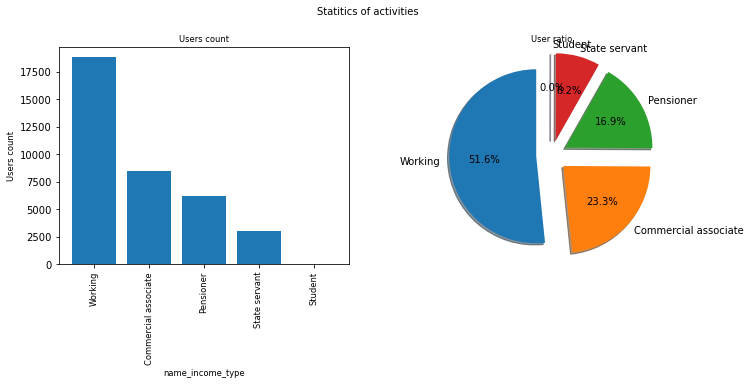

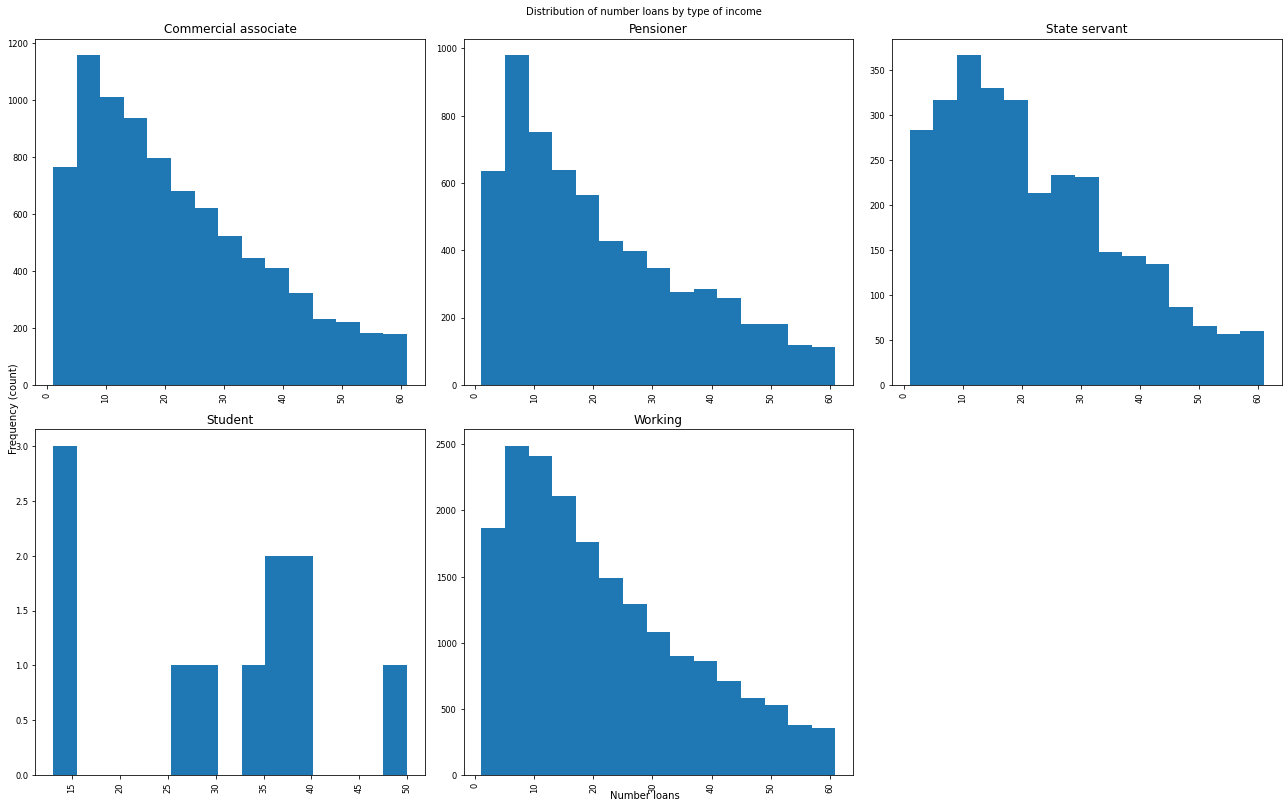

In [36]:
merge_dataframe_columnX_id_loanid_with_histogram_multiclass(df, 'name_income_type', 'type of income')

Total de user ids: 36457
Total de loans ids: 777715

 Plotting table with percentages


,name_education_type,Users_count,Loans_count,percentage
0,Secondary / secondary special,24777,524261,67.962257
1,Higher education,9864,213633,27.056532
2,Incomplete higher,1410,30329,3.867570
3,Lower secondary,374,8655,1.025866
4,Academic degree,32,837,0.087775


5


/home/marchelo/anaconda3/envs/kue_mle/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


List of education level (5)
- Secondary / secondary special
- Higher education
- Academic degree
- Incomplete higher
- Lower secondary

 Plotting distribution of number loans by education level:


/home/marchelo/anaconda3/envs/kue_mle/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:403: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds,
/home/marchelo/anaconda3/envs/kue_mle/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


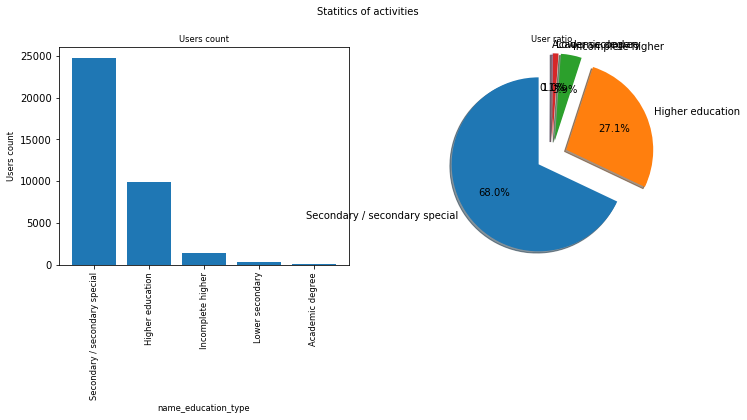

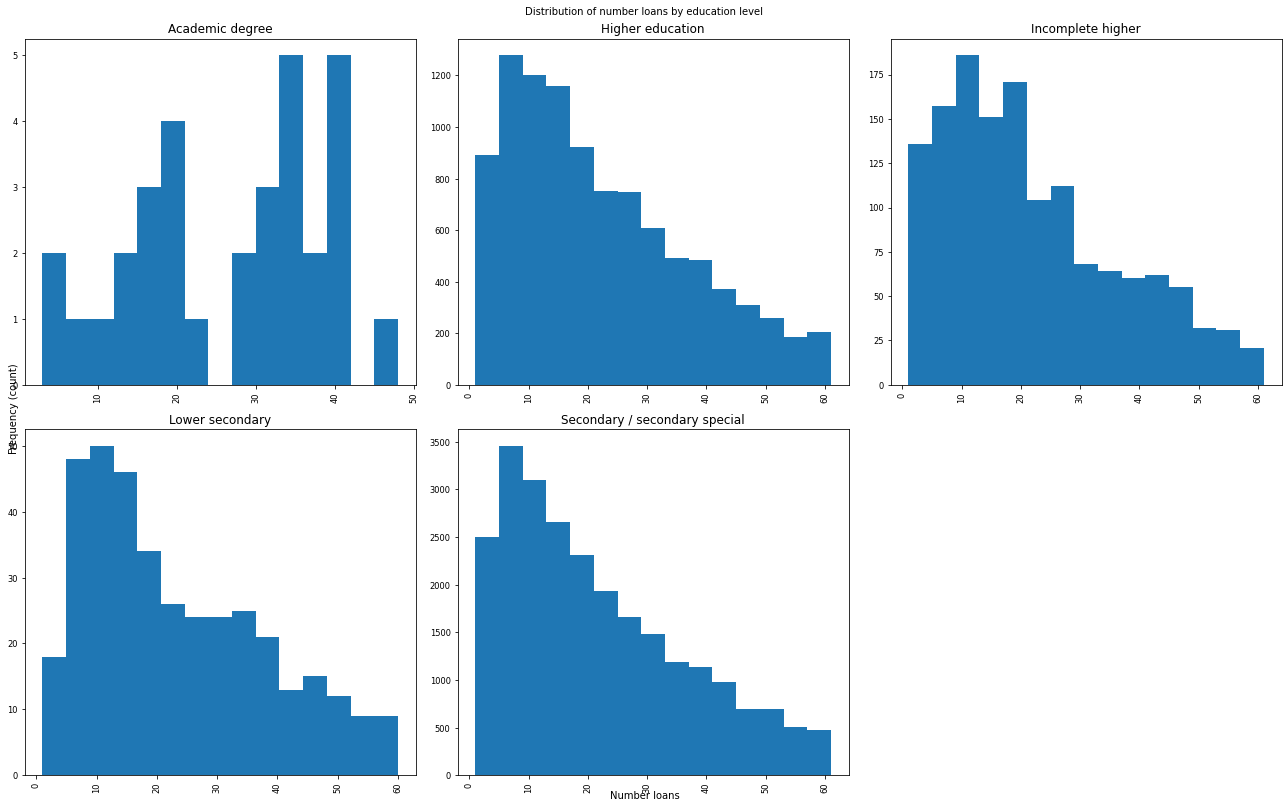

In [37]:
merge_dataframe_columnX_id_loanid_with_histogram_multiclass(df, 'name_education_type', 'education level')

Total de user ids: 36457
Total de loans ids: 777715

 Plotting table with percentages


,name_family_status,Users_count,Loans_count,percentage
0,Married,25048,546619,68.705598
1,Single / not married,4829,94335,13.245742
2,Civil marriage,2945,60342,8.078010
3,Separated,2103,45255,5.768440
4,Widow,1532,31164,4.202211


5


/home/marchelo/anaconda3/envs/kue_mle/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


List of marital status (5)
- Married
- Widow
- Civil marriage
- Separated
- Single / not married

 Plotting distribution of number loans by marital status:


/home/marchelo/anaconda3/envs/kue_mle/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:403: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds,
/home/marchelo/anaconda3/envs/kue_mle/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


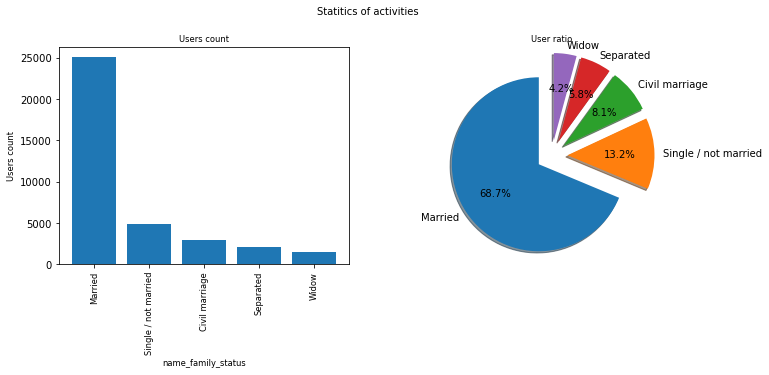

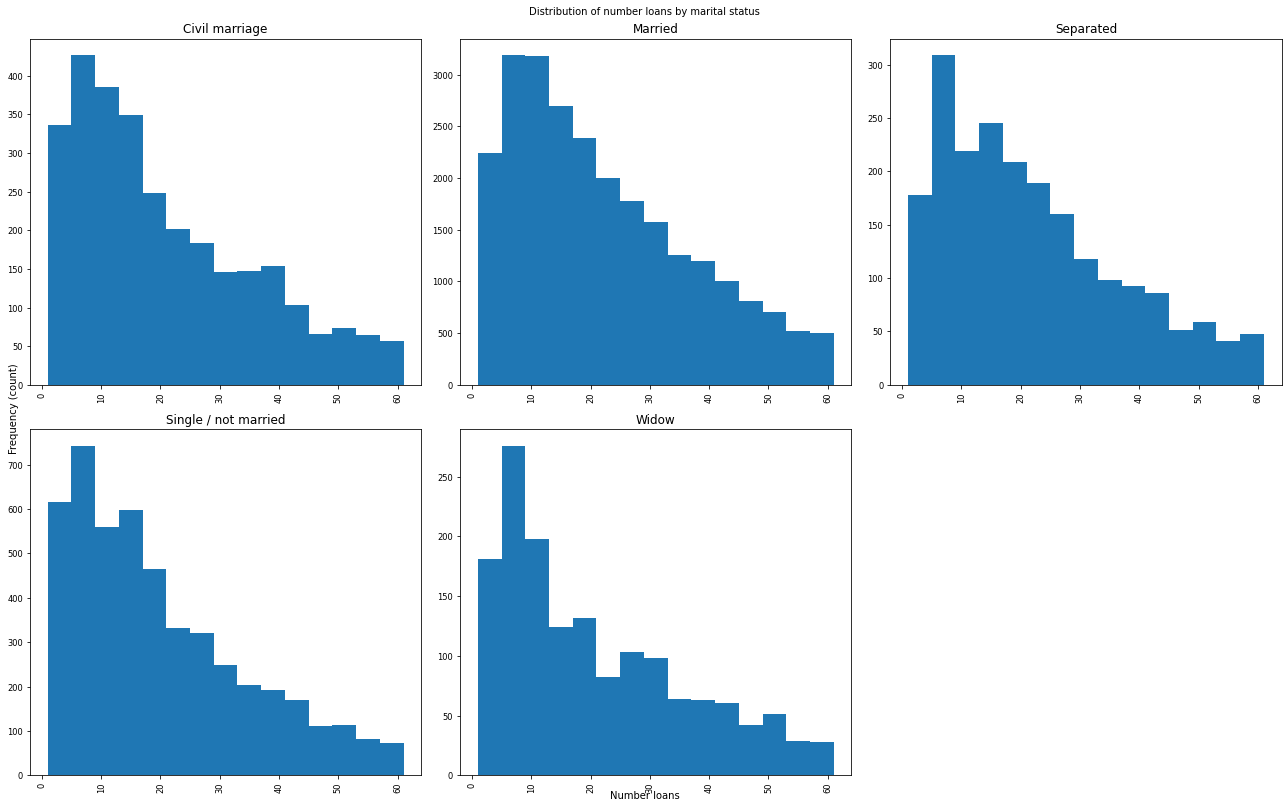

In [38]:
merge_dataframe_columnX_id_loanid_with_histogram_multiclass(df, 'name_family_status', 'marital status')

Total de user ids: 36457
Total de loans ids: 777715

 Plotting table with percentages


,name_housing_type,Users_count,Loans_count,percentage
0,House / apartment,32548,697151,89.277779
1,With parents,1776,35735,4.871492
2,Municipal apartment,1128,24640,3.094056
3,Rented apartment,575,10898,1.577201
4,Office apartment,262,5636,0.718655
5,Co-op apartment,168,3655,0.460817


6


/home/marchelo/anaconda3/envs/kue_mle/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


List of type of housing (6)
- House / apartment
- Rented apartment
- Municipal apartment
- Office apartment
- With parents
- Co-op apartment

 Plotting distribution of number loans by type of housing:


/home/marchelo/anaconda3/envs/kue_mle/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:403: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds,
/home/marchelo/anaconda3/envs/kue_mle/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


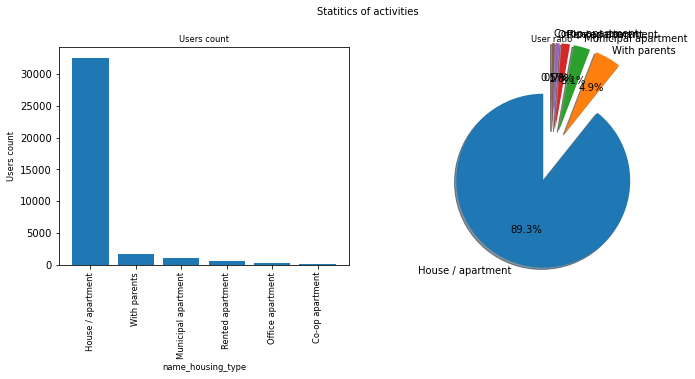

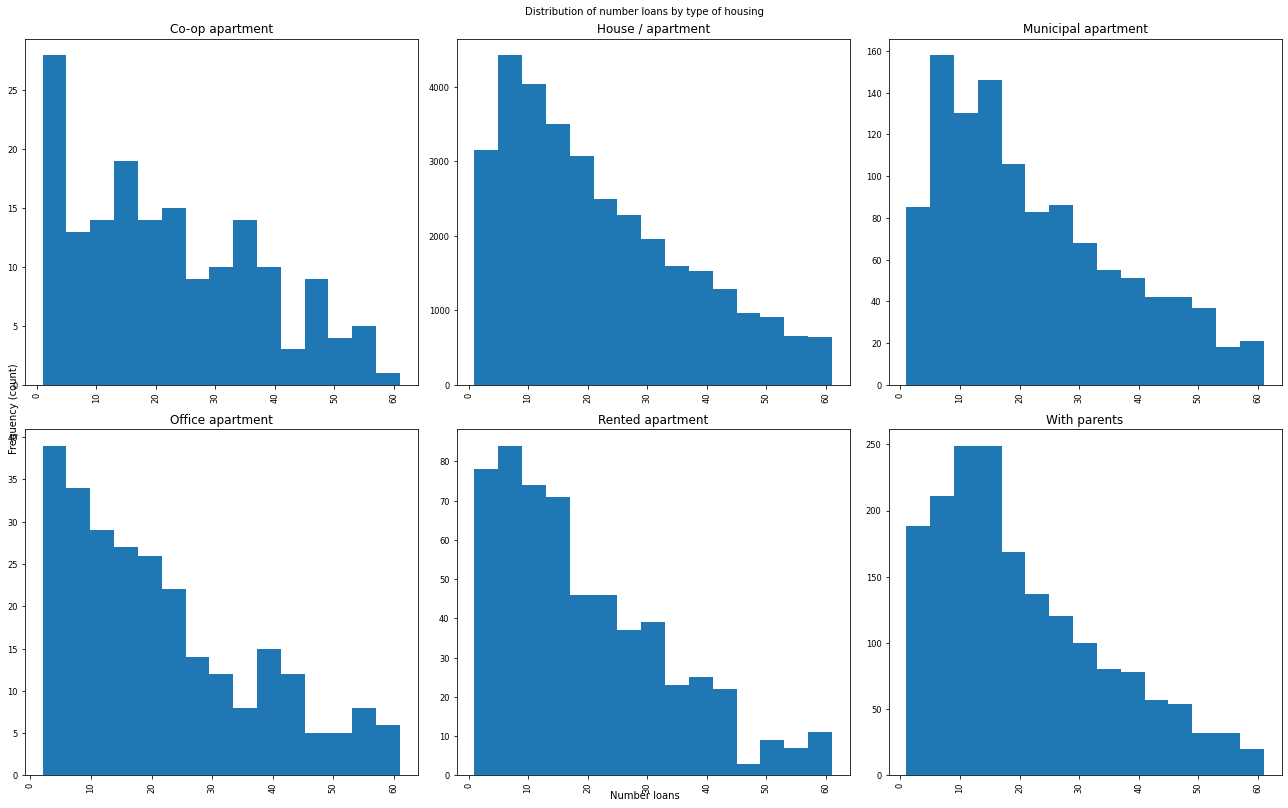

In [39]:
merge_dataframe_columnX_id_loanid_with_histogram_multiclass(df, 'name_housing_type', 'type of housing')

Total de user ids: 36457
Total de loans ids: 777715

 Plotting table with percentages


,occupation_type,Users_count,Loans_count,percentage
0,No Determinado,11323,240048,31.058507
1,Laborers,6211,131572,17.036509
2,Core staff,3591,77112,9.849960
3,Sales staff,3485,70362,9.559207
4,Managers,3012,67738,8.261788
5,Drivers,2138,47678,5.864443
6,High skill tech staff,1383,31768,3.793510
7,Accountants,1241,27223,3.404010
8,Medicine staff,1207,26691,3.310750
9,Cooking staff,655,13416,1.796637


19


/home/marchelo/anaconda3/envs/kue_mle/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


List of occupation (19)
- Laborers
- No Determinado
- Core staff
- Managers
- Sales staff
- High skill tech staff
- Cooking staff
- Drivers
- Medicine staff
- Accountants
- Cleaning staff
- Low-skill Laborers
- Private service staff
- Realty agents
- Security staff
- Secretaries
- IT staff
- Waiters/barmen staff
- HR staff

 Plotting distribution of number loans by occupation:


/home/marchelo/anaconda3/envs/kue_mle/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:403: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds,
/home/marchelo/anaconda3/envs/kue_mle/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


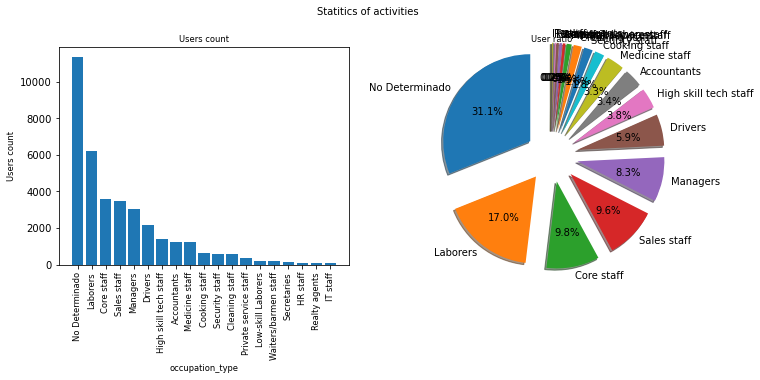

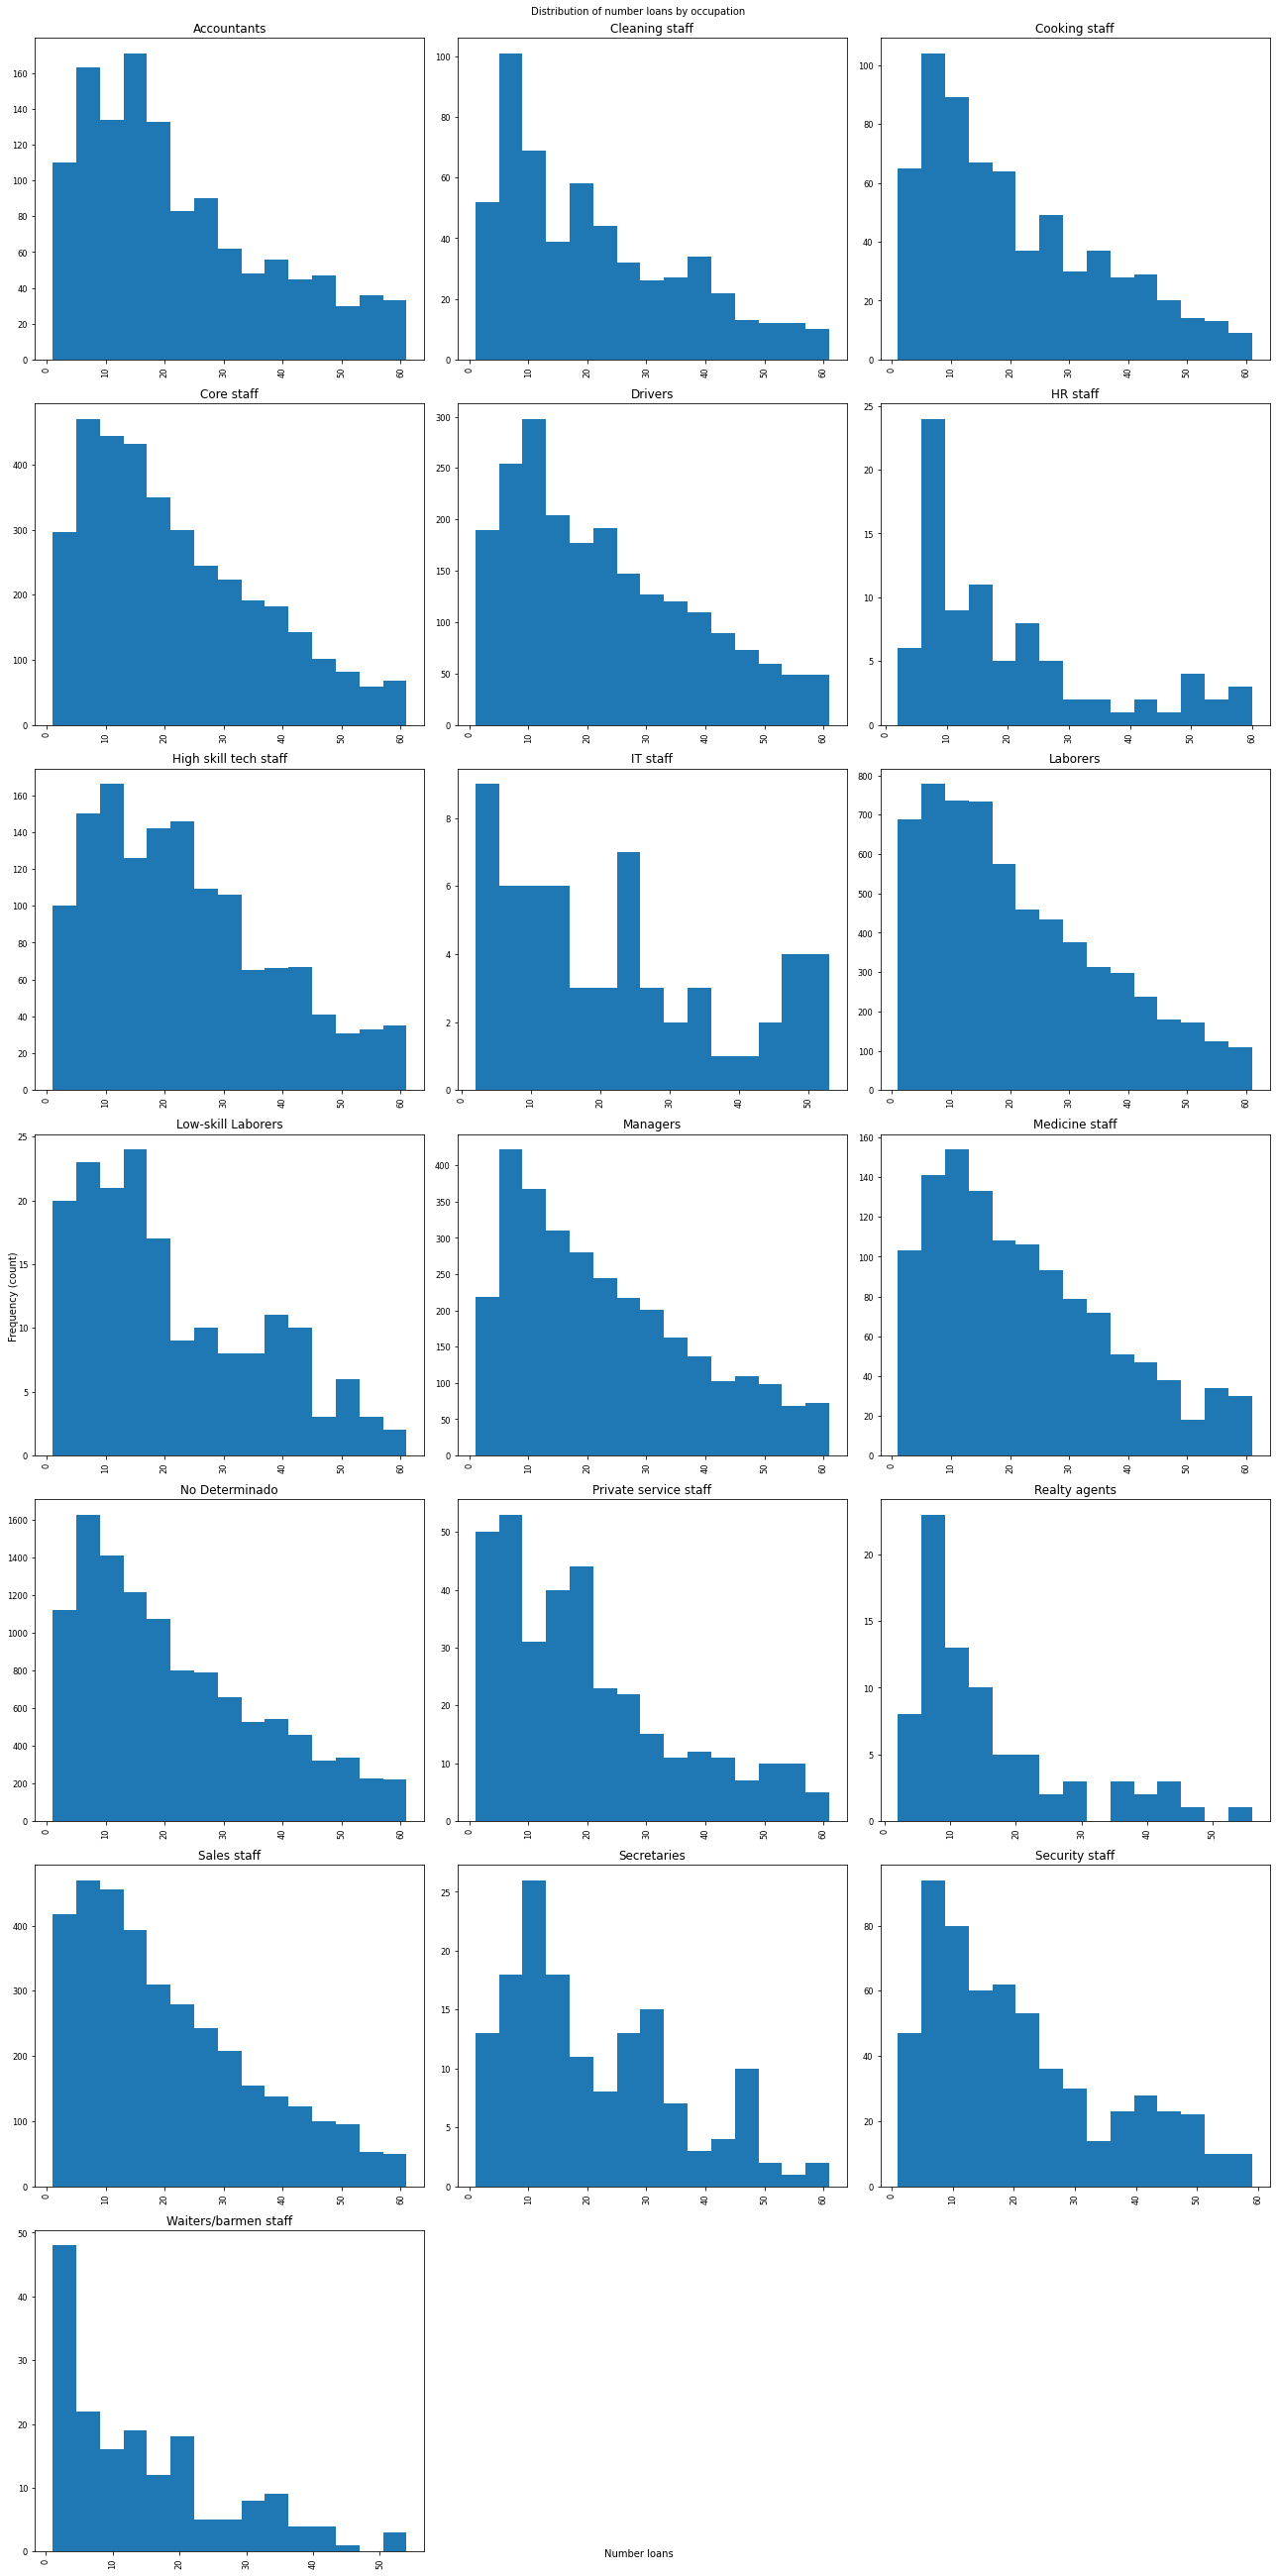

In [40]:
merge_dataframe_columnX_id_loanid_with_histogram_multiclass(df, 'occupation_type', 'occupation')

# Plots and statistics for (multicategorical columns,bicategorical columns) pairs

Analysis over the following interesting pairs:
- (name_income_type) vs (flag_own_car, flag_own_realty, code_gender)
- (name_education_type) vs (flag_mobil, flag_email)
- (name_housing_type) vs (flag_own_car, flag_own_realty)
- (name_family_status) vs (flag_own_car, flag_phone, flag_work_phone)
- (occupation_type) vs (flag_own_car, flag_own_realty)

Overall of name_income_type & code_gender vs counts loans


,name_income_type,F,M,total
4,Working,242241,157923,400164
0,Commercial associate,118997,64388,183385
1,Pensioner,109405,18987,128392
2,State servant,47886,17551,65437
3,Student,322,15,337



 Plot type of income vs gender for all loans


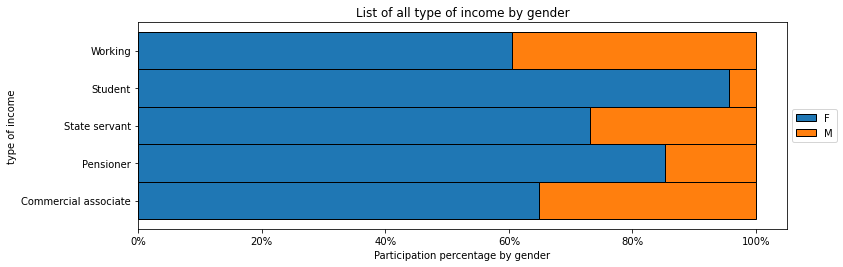

In [41]:
merge_df_plot_stat_multiColumn_vs_biColumn(df,'name_income_type', 'type of income','code_gender','gender')

Overall of name_income_type & flag_own_car vs counts loans


,name_income_type,N,Y,total
4,Working,229167,170997,400164
0,Commercial associate,102990,80395,183385
1,Pensioner,100435,27957,128392
2,State servant,40426,25011,65437
3,Student,337,0,337



 Plot type of income vs own car for all loans


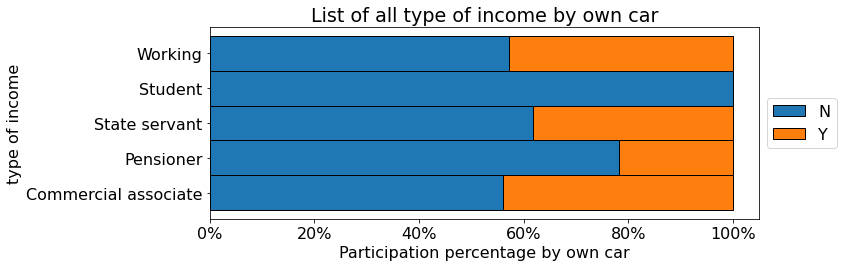

In [42]:
merge_df_plot_stat_multiColumn_vs_biColumn(df,'name_income_type', 'type of income','flag_own_car','own car')

Overall of name_income_type & flag_own_realty vs counts loans


,name_income_type,N,Y,total
4,Working,146113,254051,400164
0,Commercial associate,63502,119883,183385
1,Pensioner,31144,97248,128392
2,State servant,23993,41444,65437
3,Student,15,322,337



 Plot type of income vs own realty for all loans


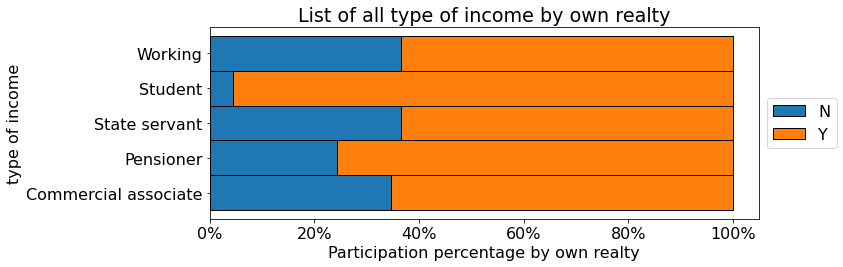

In [43]:
merge_df_plot_stat_multiColumn_vs_biColumn(df,'name_income_type', 'type of income','flag_own_realty','own realty')

Overall of name_education_type & flag_own_car vs counts loans


,name_education_type,N,Y,total
4,Secondary / secondary special,336326,187935,524261
1,Higher education,113442,100191,213633
2,Incomplete higher,17347,12982,30329
3,Lower secondary,5982,2673,8655
0,Academic degree,258,579,837



 Plot education level vs own car for all loans


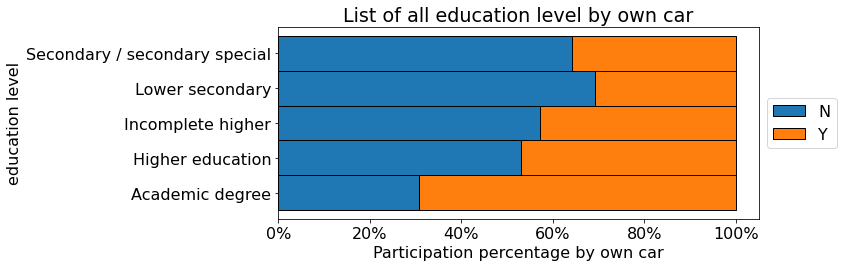

In [44]:
merge_df_plot_stat_multiColumn_vs_biColumn(df,'name_education_type', 'education level','flag_own_car','own car')

Overall of name_education_type & flag_email vs counts loans


,name_education_type,0,1,total
4,Secondary / secondary special,485628,38633,524261
1,Higher education,184723,28910,213633
2,Incomplete higher,26953,3376,30329
3,Lower secondary,8277,378,8655
0,Academic degree,837,0,837



 Plot education level vs have email for all loans


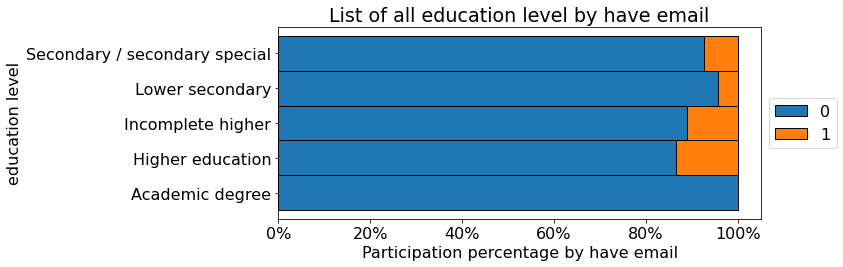

In [45]:
merge_df_plot_stat_multiColumn_vs_biColumn(df,'name_education_type', 'education level','flag_email','have email')

Overall of name_housing_type & flag_own_car vs counts loans


,name_housing_type,N,Y,total
1,House / apartment,425851,271300,697151
5,With parents,20202,15533,35735
2,Municipal apartment,16605,8035,24640
4,Rented apartment,6653,4245,10898
3,Office apartment,2660,2976,5636
0,Co-op apartment,1384,2271,3655



 Plot type of housing vs own car for all loans


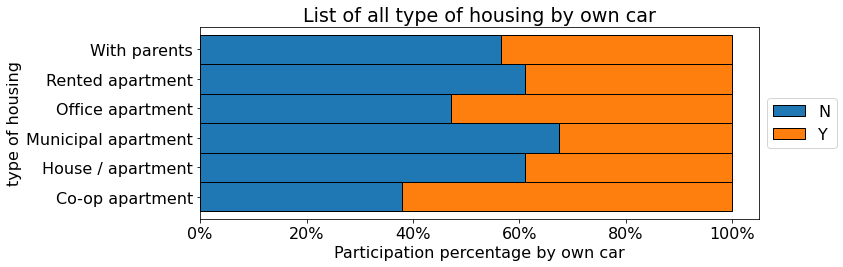

In [46]:
merge_df_plot_stat_multiColumn_vs_biColumn(df,'name_housing_type', 'type of housing','flag_own_car','own car')

Overall of name_housing_type & flag_own_realty vs counts loans


,name_housing_type,N,Y,total
1,House / apartment,214984,482167,697151
5,With parents,23725,12010,35735
2,Municipal apartment,15957,8683,24640
4,Rented apartment,5131,5767,10898
3,Office apartment,3314,2322,5636
0,Co-op apartment,1656,1999,3655



 Plot type of housing vs own realty for all loans


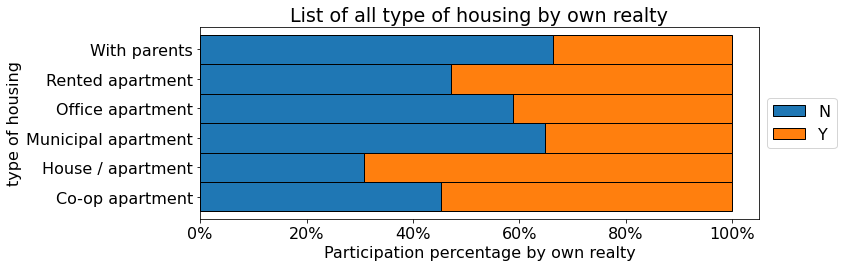

In [47]:
merge_df_plot_stat_multiColumn_vs_biColumn(df,'name_housing_type', 'type of housing','flag_own_realty','own realty')

Overall of name_family_status & flag_own_car vs counts loans


,name_family_status,N,Y,total
1,Married,306164,240455,546619
3,Single / not married,67439,26896,94335
0,Civil marriage,40180,20162,60342
2,Separated,33832,11423,45255
4,Widow,25740,5424,31164



 Plot marital status vs own car for all loans


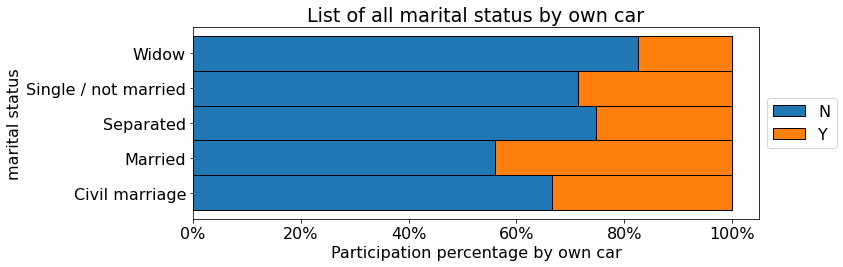

In [48]:
merge_df_plot_stat_multiColumn_vs_biColumn(df,'name_family_status', 'marital status','flag_own_car','own car')

Overall of name_family_status & flag_phone vs counts loans


,name_family_status,0,1,total
1,Married,377704,168915,546619
3,Single / not married,69296,25039,94335
0,Civil marriage,44140,16202,60342
2,Separated,30505,14750,45255
4,Widow,22005,9159,31164



 Plot marital status vs have phone for all loans


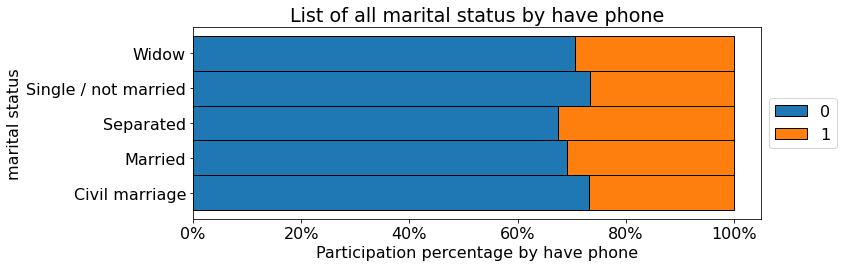

In [49]:
merge_df_plot_stat_multiColumn_vs_biColumn(df,'name_family_status', 'marital status','flag_phone','have phone')

Overall of name_family_status & flag_work_phone vs counts loans


,name_family_status,0,1,total
1,Married,413527,133092,546619
3,Single / not married,75687,18648,94335
0,Civil marriage,45231,15111,60342
2,Separated,35404,9851,45255
4,Widow,27578,3586,31164



 Plot marital status vs have work phone for all loans


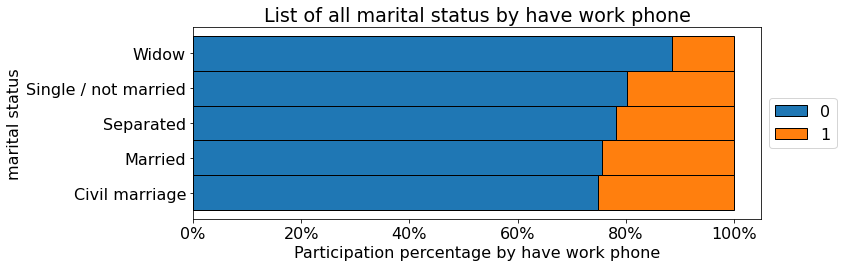

In [50]:
merge_df_plot_stat_multiColumn_vs_biColumn(df,'name_family_status', 'marital status','flag_work_phone','have work phone')

Overall of occupation_type & code_gender vs counts loans


,occupation_type,F,M,total
12,No Determinado,185019,55029,240048
8,Laborers,56403,75169,131572
3,Core staff,61587,15525,77112
15,Sales staff,61736,8626,70362
10,Managers,35638,32100,67738
4,Drivers,2850,44828,47678
6,High skill tech staff,21895,9873,31768
0,Accountants,26572,651,27223
11,Medicine staff,25683,1008,26691
2,Cooking staff,12000,1416,13416



 Plot occupation vs gender for all loans


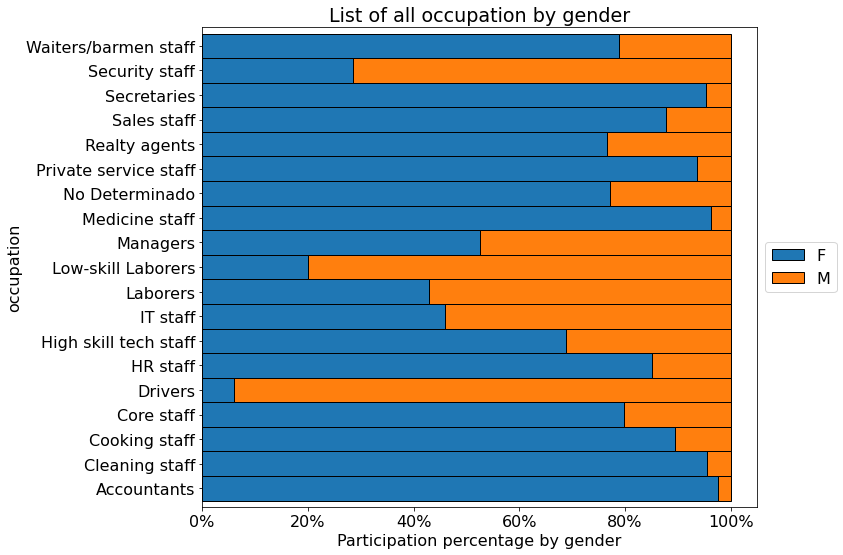

In [51]:
merge_df_plot_stat_multiColumn_vs_biColumn(df,'occupation_type', 'occupation','code_gender','gender')

Overall of occupation_type & flag_own_car vs counts loans


,occupation_type,N,Y,total
12,No Determinado,167148,72900,240048
8,Laborers,74733,56839,131572
3,Core staff,47914,29198,77112
15,Sales staff,47518,22844,70362
10,Managers,27672,40066,67738
4,Drivers,12327,35351,47678
6,High skill tech staff,17075,14693,31768
0,Accountants,16690,10533,27223
11,Medicine staff,18884,7807,26691
2,Cooking staff,10652,2764,13416



 Plot occupation vs own car for all loans


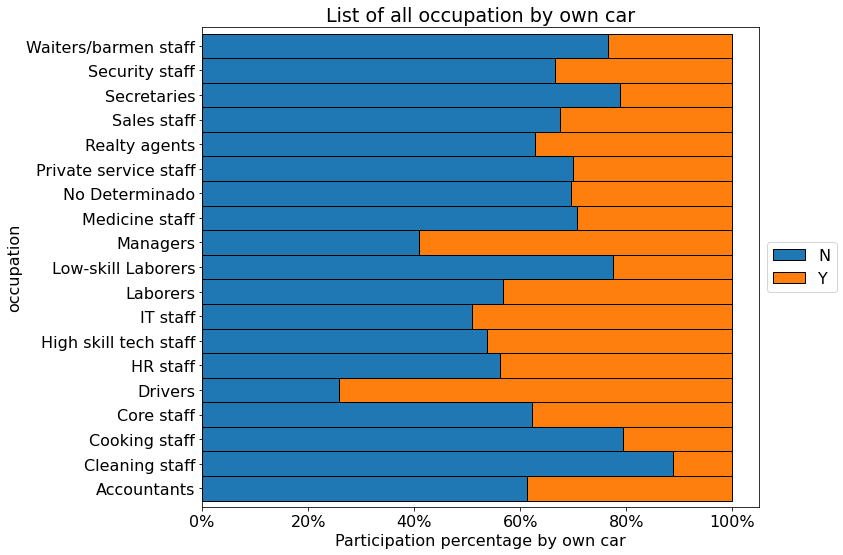

In [52]:
merge_df_plot_stat_multiColumn_vs_biColumn(df,'occupation_type', 'occupation','flag_own_car','own car')

Overall of occupation_type & flag_own_realty vs counts loans


,occupation_type,N,Y,total
12,No Determinado,72571,167477,240048
8,Laborers,48888,82684,131572
3,Core staff,26584,50528,77112
15,Sales staff,24442,45920,70362
10,Managers,22708,45030,67738
4,Drivers,19161,28517,47678
6,High skill tech staff,11307,20461,31768
0,Accountants,10004,17219,27223
11,Medicine staff,9565,17126,26691
2,Cooking staff,4984,8432,13416



 Plot occupation vs realty for all loans


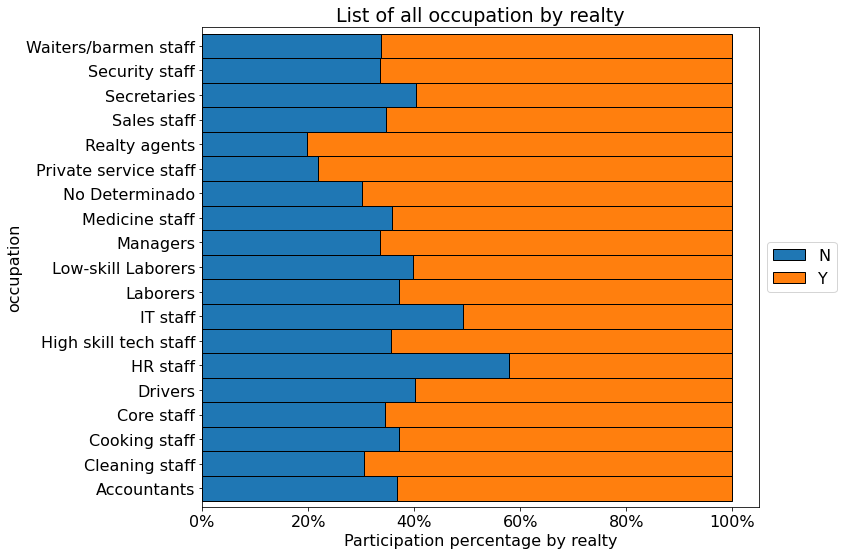

In [53]:
merge_df_plot_stat_multiColumn_vs_biColumn(df,'occupation_type', 'occupation','flag_own_realty','realty')

# Exploratory analysis for loans

In [54]:
# grouped_df = empDF.groupby("id") \
#                 .agg(functions.sort_array(functions.collect_list(functions.struct("date", "value"))) \
#                 .alias("collected_list")) \
#                 .withColumn("value_list",col("collected_list.value")) \
#                 .withColumn("date_list",col("collected_list.date")) \
#                 .drop("collected_list") \
#                 .show(truncate=False)


dfLoans = df.select('id','loan_amount','loan_date','amt_income_total') \
            .groupBy('id') \
            .agg(functions.sort_array(
                    functions.collect_list(functions.struct('loan_date','loan_amount','amt_income_total'))) \
                    .alias('collected_list')) \
            .withColumn('loan_amount_array', col('collected_list.loan_amount')) \
            .withColumn('amt_income_total_array', col('collected_list.amt_income_total')) \
            .withColumn('loan_date_array', col('collected_list.loan_date')) \
            .drop('collected_list')

dfLoans.show(5)

+-------+--------------------+----------------------+--------------------+
|     id|   loan_amount_array|amt_income_total_array|     loan_date_array|
+-------+--------------------+----------------------+--------------------+
|5009033|[108.704375791507...|  [255150.0, 255150...|[2019-02-24 00:00...|
|5009304|[134.948762091350...|  [112500.0, 112500...|[2019-01-22 00:00...|
|5009355|[100.449767982632...|  [135000.0, 135000...|[2019-01-15 00:00...|
|5009429|[116.951732985245...|  [198000.0, 198000...|[2020-04-24 00:00...|
|5010070|[114.257105858043...|  [279000.0, 279000...|[2019-02-13 00:00...|
+-------+--------------------+----------------------+--------------------+
only showing top 5 rows



In [55]:
dfArrayLoansInformation = df.select('id','loan_amount','loan_date','amt_income_total') \
            .groupBy('id') \
            .agg(functions.sort_array(
                    functions.collect_list(functions.struct('loan_date','loan_amount','amt_income_total'))) \
                    .alias('collected_list')) \
            .withColumn('loan_amount_array', col('collected_list.loan_amount')) \
            .withColumn('amt_income_total_array', col('collected_list.amt_income_total')) \
            .withColumn('loan_date_array', col('collected_list.loan_date')) \
            .drop('collected_list')
                 
sum_udf_function = functions.udf(lambda x: float(np.array(x).sum()), 'float')
avg_udf_function = functions.udf(lambda x: float(np.mean(x)), 'float')
min_udf_function = functions.udf(lambda x: float(np.min(x)), 'float')
max_udf_function = functions.udf(lambda x: float(np.max(x)), 'float')
len_udf_function = functions.udf(lambda x: len(x), 'int')               

dfArrayLoansInformation = dfArrayLoansInformation \
                    .withColumn('sumLoanAmount', sum_udf_function('loan_amount_array')) \
                    .withColumn('avgLoanAmount', avg_udf_function('loan_amount_array')) \
                    .withColumn('minLoanAmount', min_udf_function('loan_amount_array')) \
                    .withColumn('maxLoanAmount', max_udf_function('loan_amount_array')) \
                    .withColumn('countLoan', len_udf_function('loan_amount_array')) \
                    .withColumn('avgAmountIncome', avg_udf_function('amt_income_total_array')) \
                    .withColumn('minAmountIncome', min_udf_function('amt_income_total_array')) \
                    .withColumn('maxAmountIncome', max_udf_function('amt_income_total_array'))
                 
dfArrayLoansInformation = dfArrayLoansInformation.select('id','countLoan','avgLoanAmount', 'avgAmountIncome',
                                                         'sumLoanAmount','minLoanAmount','maxLoanAmount', 
                                                         'minAmountIncome','maxAmountIncome', 
                                                         'loan_amount_array', 'loan_date_array', 'amt_income_total_array')                 
                 
dfArrayLoansInformation = dfArrayLoansInformation.orderBy(col('countLoan').desc())

dfArrayLoansInformationPd = dfArrayLoansInformation.toPandas()
dfArrayLoansInformationPd    

,id,countLoan,avgLoanAmount,avgAmountIncome,sumLoanAmount,minLoanAmount,maxLoanAmount,minAmountIncome,maxAmountIncome,loan_amount_array,loan_date_array,amt_income_total_array
0,5091644,61,130.680115,135000.0,7971.486328,100.082031,397.498657,135000.0,135000.0,"[133.87406575510153, 102.34405640892591, 158.2...","[2019-01-05 00:00:00, 2019-01-11 00:00:00, 201...","[135000.0, 135000.0, 135000.0, 135000.0, 13500..."
1,5106019,61,127.721039,211500.0,7790.983398,100.856667,276.507477,211500.0,211500.0,"[118.28730616350747, 102.06493480285576, 124.4...","[2019-01-21 00:00:00, 2019-02-24 00:00:00, 201...","[211500.0, 211500.0, 211500.0, 211500.0, 21150..."
2,5054051,61,136.606400,112500.0,8332.990234,101.556442,337.647247,112500.0,112500.0,"[106.84803257044096, 154.716875000812, 155.329...","[2019-01-12 00:00:00, 2019-02-05 00:00:00, 201...","[112500.0, 112500.0, 112500.0, 112500.0, 11250..."
3,5061434,61,130.650604,292500.0,7969.687012,100.043999,243.842590,292500.0,292500.0,"[221.57684249723275, 104.7691309042862, 154.20...","[2019-01-22 00:00:00, 2019-01-23 00:00:00, 201...","[292500.0, 292500.0, 292500.0, 292500.0, 29250..."
4,5061848,61,129.717926,157500.0,7912.792969,100.056564,245.563980,157500.0,157500.0,"[105.15219966977992, 150.9858443466344, 110.33...","[2019-01-06 00:00:00, 2019-01-06 00:00:00, 201...","[157500.0, 157500.0, 157500.0, 157500.0, 15750..."
...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5054740,1,127.315163,247500.0,127.315163,127.315163,127.315163,247500.0,247500.0,[127.31516215032207],[2019-12-17 00:00:00],[247500.0]
36453,5105145,1,106.216316,90000.0,106.216316,106.216316,106.216316,90000.0,90000.0,[106.21631953477626],[2019-10-12 00:00:00],[90000.0]
36454,5146001,1,100.194801,157500.0,100.194801,100.194801,100.194801,157500.0,157500.0,[100.19480464407629],[2019-07-04 00:00:00],[157500.0]
36455,5010291,1,116.320694,126000.0,116.320694,116.320694,116.320694,126000.0,126000.0,[116.32069398250894],[2019-04-11 00:00:00],[126000.0]


In [57]:
dfTempLimit = dfArrayLoansInformation
dfTempLimitPd = dfTempLimit.toPandas()
# display(dfTempLimitPd)
countGood, countBad = 0, 0
goodId = []
for index,data_row in dfTempLimitPd.iterrows():    
    min_date_time = min(data_row['loan_date_array'])
    if min(data_row['loan_date_array']) != data_row['loan_date_array'][0]:
#         print(min_date_time)
#         print(data_row['loan_date_array'][:5])
        countBad = countBad + 1
    else:
        countGood = countGood +1
        goodId.append(data_row['id'])
        
print(f'numero de casos buenos: {countGood}')
print(f'numero de casos malos: {countBad}')
print(f'Casos buenos: {goodId[:5]}')

numero de casos buenos: 36457
numero de casos malos: 0
Casos buenos: [5091644, 5106019, 5054051, 5061434, 5061848]


##  General plots for loan information

In [58]:
def genHistogramByColumn(dataframe_pd, col, name_col, bins=10, figsize=(10,6)):
    print(f'\nHistogram for {name_col}')
    fig = plt.figure(figsize=figsize) 
    duration_dist = dataframe_pd.hist(column=col, bins=bins,
                                sharex = True, grid=True, figsize=figsize,
                                xlabelsize='small', ylabelsize='small')
    xlabel = plt.xlabel(f'{name_col} by user')
    ylabel = plt.ylabel('number of users')
    param_update = plt.rcParams.update({'font.size': 16});
    ax = plt.gca()
    a = fig.tight_layout()
    plt.show()


Histogram for number of loans


<Figure size 720x432 with 0 Axes>

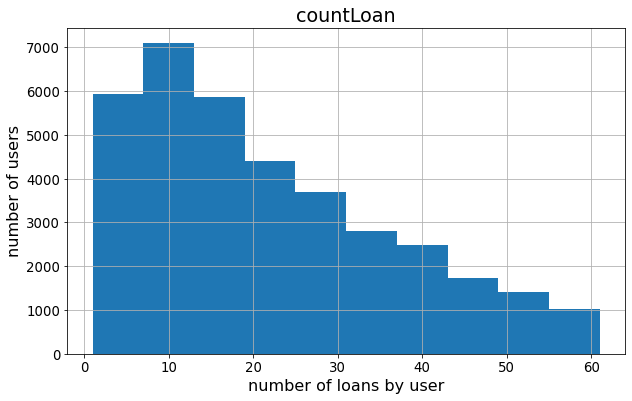

In [59]:
genHistogramByColumn(dfArrayLoansInformationPd,'countLoan','number of loans')


Histogram for average of loan amount


<Figure size 720x576 with 0 Axes>

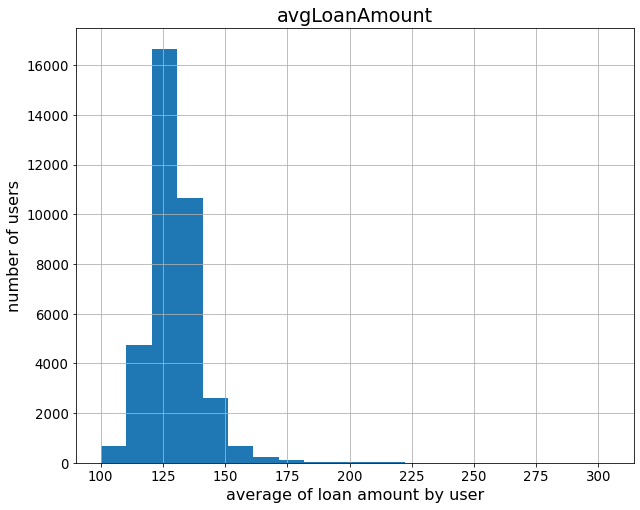

In [60]:
genHistogramByColumn(dfArrayLoansInformationPd,'avgLoanAmount','average of loan amount', 
                        bins=20, figsize=(10,8))


Histogram for average of income amount


<Figure size 1440x576 with 0 Axes>

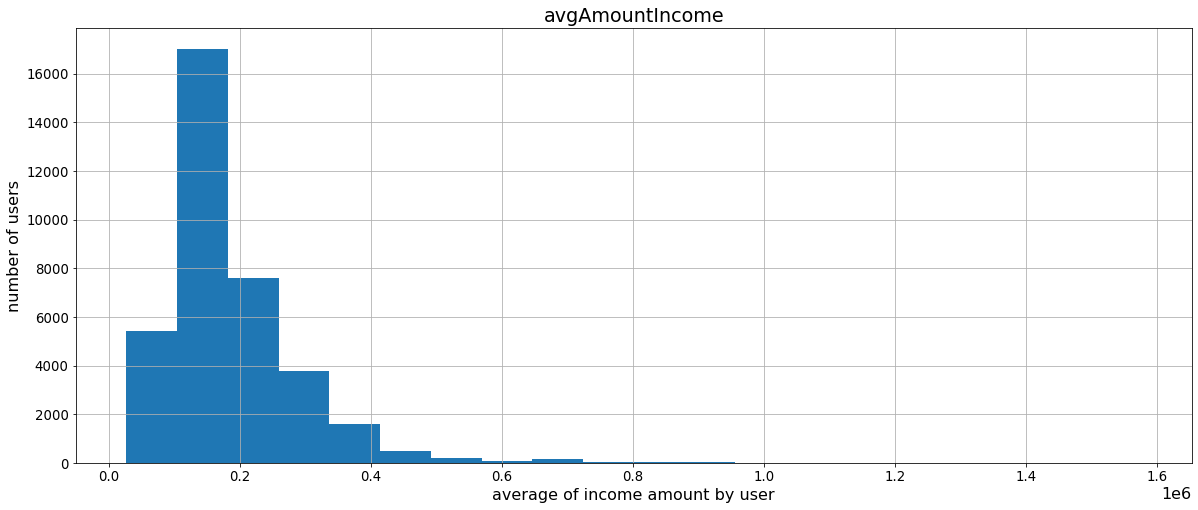

In [88]:
genHistogramByColumn(dfArrayLoansInformationPd,'avgAmountIncome','average of income amount', 
                        bins=20, figsize=(20,8))

In [302]:
def plotValueByTime(values, numberLoans):
#     values = dataframe_pd[dataframe_pd['name_income_type'] == nameIncomeTypeVal]
    
    min_time = min(flattern(values['normalized_date_time']))
    min_value = min(flattern(values['loan_amount_array']))
    
    max_time = max(flattern(values['normalized_date_time']))
    max_value = max(flattern(values['loan_amount_array']))  
    
    fig, axs = plt.subplots(figsize=(12,8))
    subplot_adj = fig.subplots_adjust(hspace = 0.6)
    plot_setp = plt.setp(axs, 
                         yticks=range(min_time,int(max_value),20), 
                         xticks=range(0,int(max_time),20))
    
    for _, data_row in values.iterrows():
        label = 'user: ' + str(data_row['id'])
        plot_i = axs.plot(data_row['normalized_date_time'], 
                          data_row['loan_amount_array'], 
                          label=label)
        
    
    title = axs.set_title('Group with number of loans: '+  numberLoans, fontsize='small')
    xlabel = axs.set_xlabel('Normalized time (days)', fontsize='small')
    xsticklabels = axs.set_xticklabels( 
                        range(0, int(max_time), 20),rotation = 'vertical', fontsize=9)
    
#     ylabel = axs.set_ylabel('Loan amount', fontsize='small')
    ysticklabels = axs.set_yticklabels(
                        range(min_time,int(max_value),20),fontsize='small')
    
    legend = axs.legend(
        loc='center left', bbox_to_anchor=(1.0, 0.5), prop={'size': 9})
    
    x_label = fig.text(0.04, 0.5, 'Loan Amount', va='center', rotation='vertical')
    chart_title = fig.text(0.5,1.08,'Loan Amount rate  by normalized time', 
            ha='center', va='center', fontsize='small', transform=axs.transAxes)
    
def generateAndDFForPlotValueByTime(dataframePd, numberLoan):
    dataframeTemp = dataframePd[dataframePd['countLoan']==numberLoan]
    dataframeTemp = dataframeTemp.sample(n=minNumUsersByGroup)
    plotValueByTime(dataframeTemp, str(numberLoan))

# plotValueByTime(dfTempPd, 'Pensioner')
# generateAndDFForPlotValueByTime(dfArrayLoansInformationPd,5)

In [285]:
normalized_datetime_list = []
for index,data_row in dfArrayLoansInformationPd.iterrows():
    min_date_time = min(data_row['loan_date_array'])
    normalized_datetime_list.append(
        [(date_time - min_date_time).days for date_time in data_row['loan_date_array']]
    )

dfArrayLoansInformationPd['normalized_date_time'] = normalized_datetime_list

In [286]:
print("\n Number of users by number of loans")
dfLoanCountByUsersPd = dfArrayLoansInformationPd[['id','countLoan']] \
                            .groupby('countLoan').agg(['count'])
dfLoanCountByUsersPd.columns = dfLoanCountByUsersPd.columns.droplevel(0)
dfLoanCountByUsersPd['numberLoans'] = dfLoanCountByUsersPd.index
# dfLoanCountByUsersPd.columns = ['countLoan','numberUsersByCountLoans']
display(dfLoanCountByUsersPd.T)


 Number of users by number of loans


countLoan,1,2,3,4,5,6,7,8,9,10,...,52,53,54,55,56,57,58,59,60,61
count,341,954,1035,1221,1115,1278,1253,1299,1212,1068,...,236,238,174,149,173,164,140,137,137,128
numberLoans,1,2,3,4,5,6,7,8,9,10,...,52,53,54,55,56,57,58,59,60,61


In [287]:
listNumberUsers = dfLoanCountByUsersPd['count'].tolist()
minListNumberUsers = int(min(listNumberUsers))
maxListNumberUsers = int(max(listNumberUsers))
print(f'Value of the group with lesser number of loan: {minListNumberUsers}')
print(f'Value of the group with greater number of loan: {maxListNumberUsers}')

Value of the group with lesser number of loan: 128
Value of the group with greater number of loan: 1299


In [303]:
minNumUsersByGroup = min(minListNumberUsers, 15)
interestGroupByNumberLoans = [5,10,15,20,30,40,50,60]

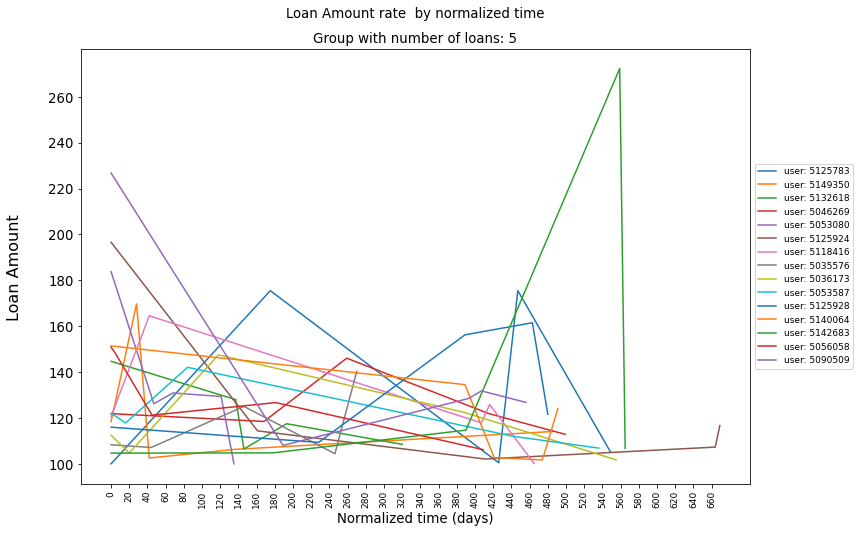

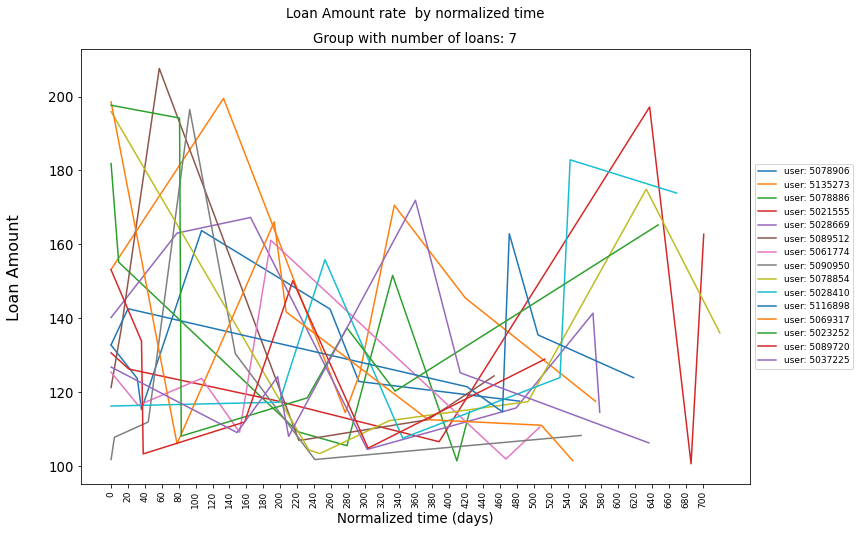

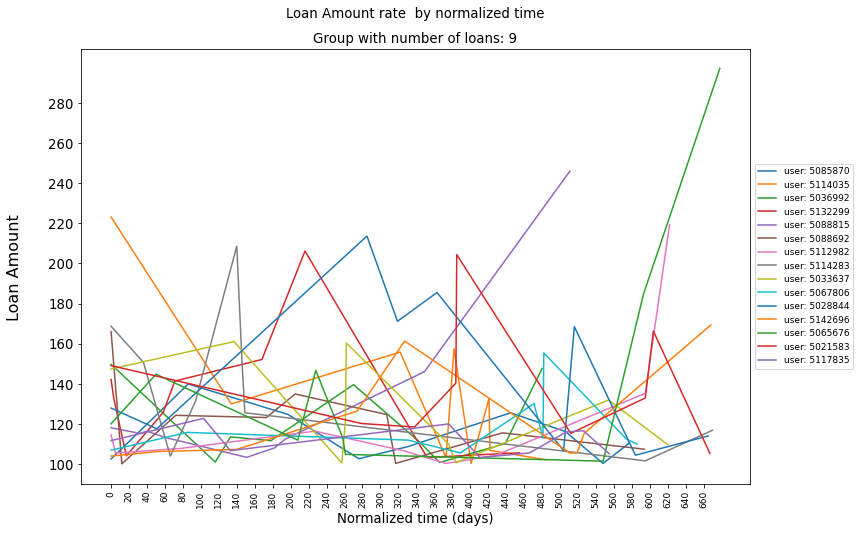

In [306]:
interestGroupByNumberLoans = [5,7,9]
for numberLoan in interestGroupByNumberLoans:
    dataframeTemp = dfArrayLoansInformationPd[dfArrayLoansInformationPd['countLoan']==numberLoan]
    dataframeTemp = dataframeTemp.sample(n=minNumUsersByGroup)
    plotValueByTime(dataframeTemp, str(numberLoan))

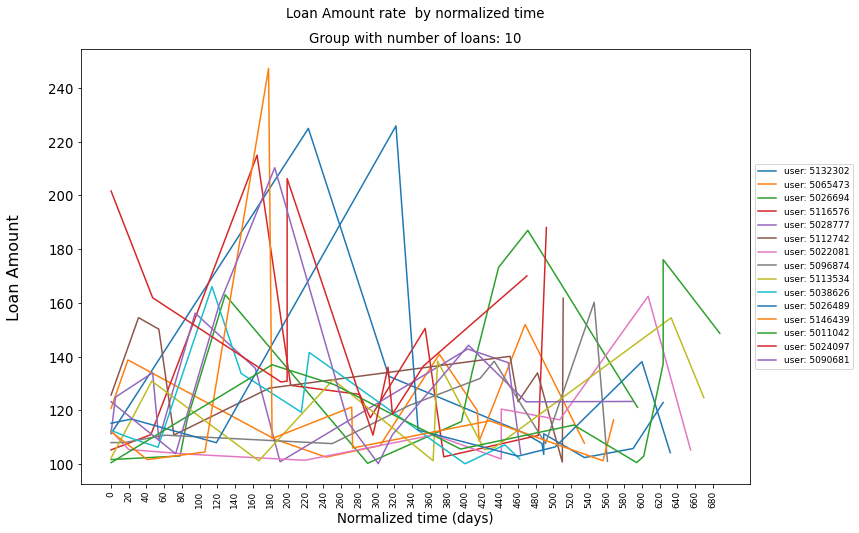

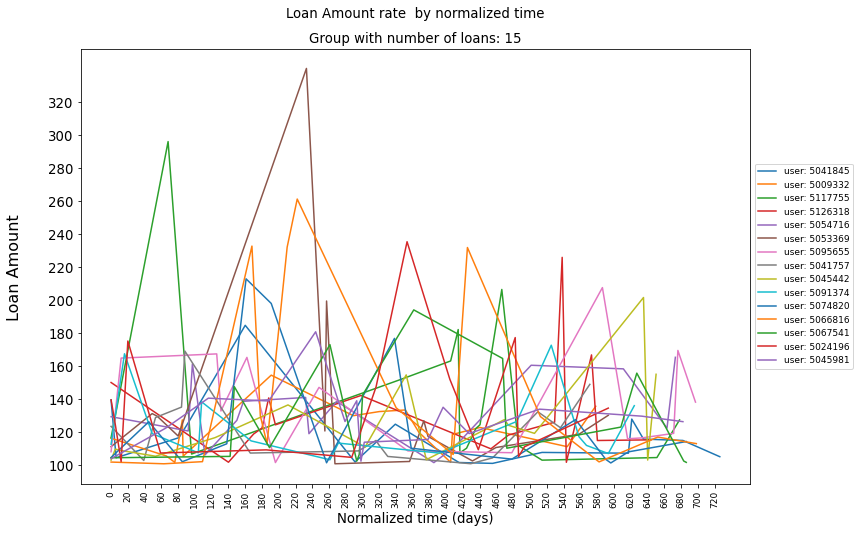

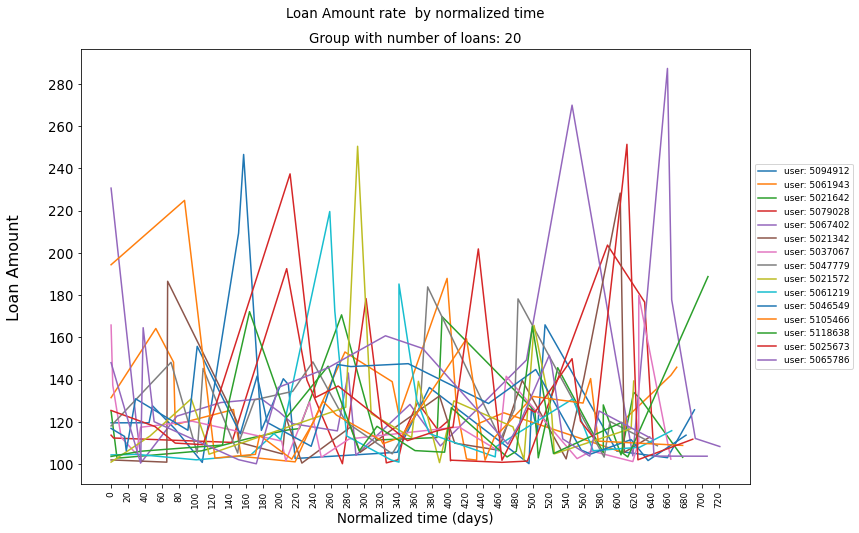

In [307]:
interestGroupByNumberLoans = [10,15,20]
for numberLoan in interestGroupByNumberLoans:
    dataframeTemp = dfArrayLoansInformationPd[dfArrayLoansInformationPd['countLoan']==numberLoan]
    dataframeTemp = dataframeTemp.sample(n=minNumUsersByGroup)
    plotValueByTime(dataframeTemp, str(numberLoan))

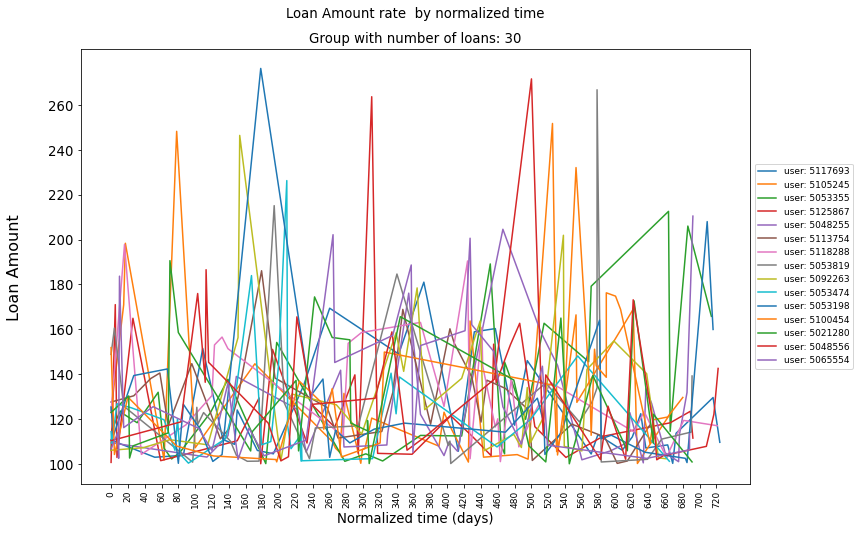

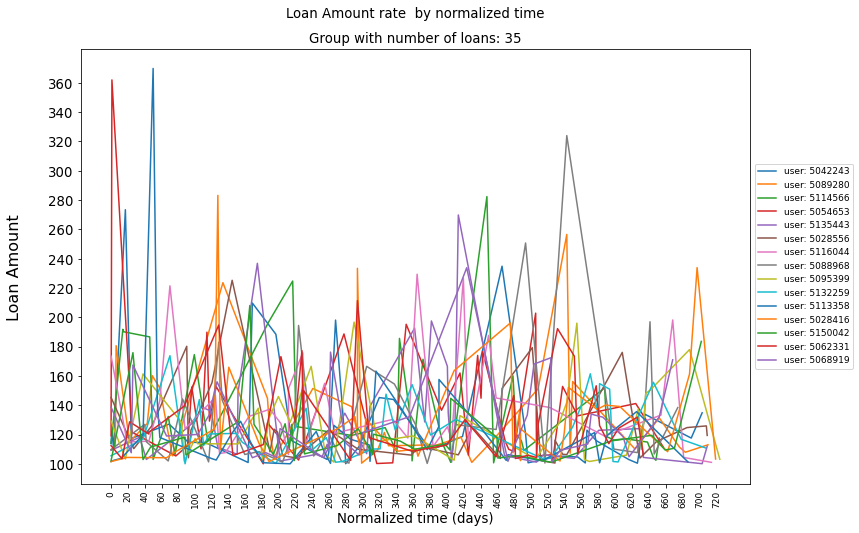

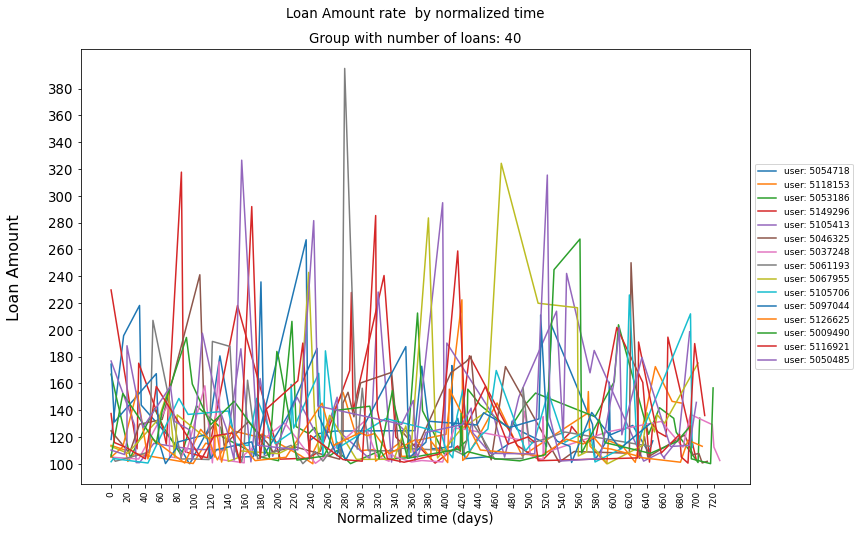

In [309]:
interestGroupByNumberLoans = [30,35,40]
for numberLoan in interestGroupByNumberLoans:
    dataframeTemp = dfArrayLoansInformationPd[dfArrayLoansInformationPd['countLoan']==numberLoan]
    dataframeTemp = dataframeTemp.sample(n=minNumUsersByGroup)
    plotValueByTime(dataframeTemp, str(numberLoan))

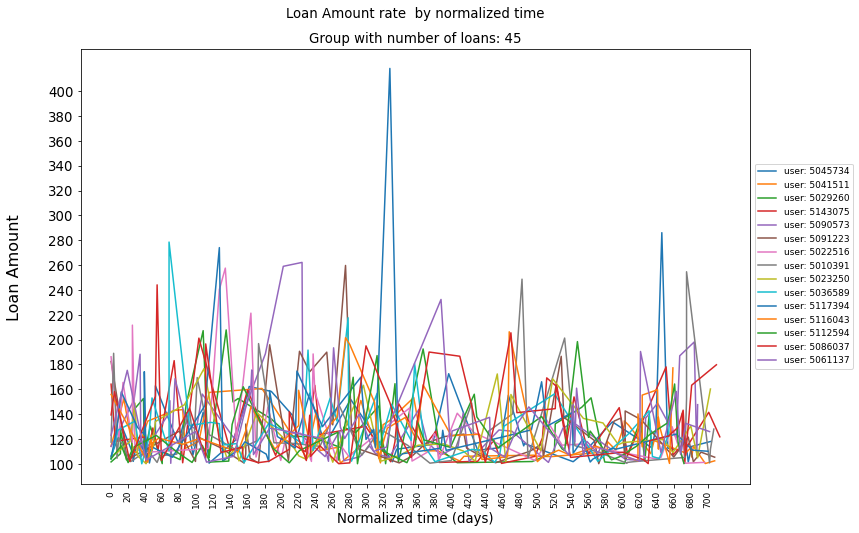

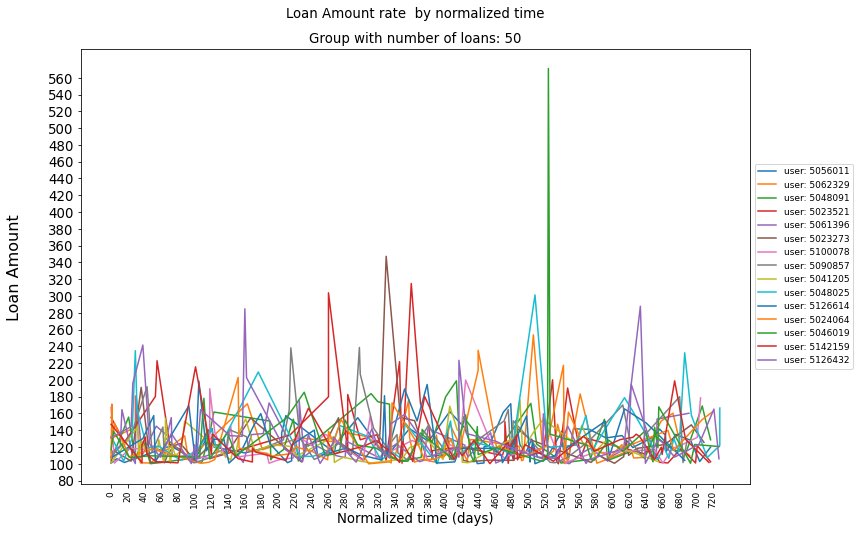

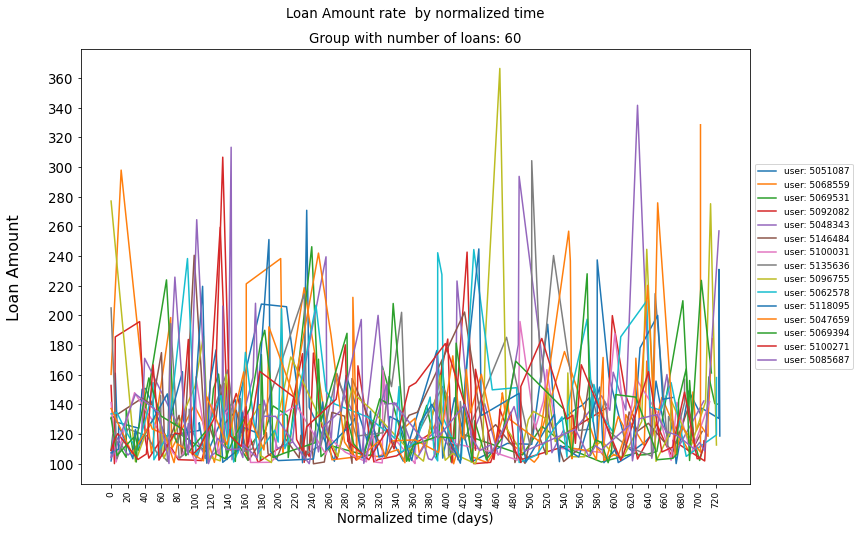

In [311]:
interestGroupByNumberLoans = [45,50,60]
for numberLoan in interestGroupByNumberLoans:
    dataframeTemp = dfArrayLoansInformationPd[dfArrayLoansInformationPd['countLoan']==numberLoan]
    dataframeTemp = dataframeTemp.sample(n=minNumUsersByGroup)
    plotValueByTime(dataframeTemp, str(numberLoan))

# Information over age, month jobs of users vs loan

In [366]:
dfDateDiffYeaBirMonJob = df.select('id','loan_id','loan_amount','loan_date','job_start_date','birthday') \
                .withColumn('yearDiffBirthDec', \
                            functions.months_between(col('loan_date'), col('birthday'))/lit(12)) \
                .withColumn('monthDiffJobDec', \
                            functions.months_between(col('loan_date'), col('job_start_date'))) \
                .withColumn('yearDiffBirth', col('yearDiffBirthDec').cast(IntegerType())) \
                .withColumn('monthDiffJob', col('monthDiffJobDec').cast(IntegerType())) \
                .drop('yearDiffBirthDec')

dfDateDiffYeaBirMonJobPd = dfDateDiffYeaBirMonJob.toPandas()
dfDateDiffYeaBirMonJobPd.head(6)

,id,loan_id,loan_amount,loan_date,job_start_date,birthday,monthDiffJobDec,yearDiffBirth,monthDiffJob
0,5044500,208089,133.714974,2019-01-01,3021-09-18 00:00:00,1955-08-04,-12032.548387,63,-12032
1,5026631,112797,158.800558,2019-01-01,1997-06-05 00:00:00,1972-03-30,258.870968,46,258
2,5036645,162434,203.608487,2019-01-01,2015-02-22 00:00:00,1987-03-24,46.322581,31,46
3,5033584,144343,113.204964,2019-01-01,2009-06-29 00:00:00,1973-03-15,114.096774,45,114
4,5085755,409695,109.376260,2019-01-01,2019-07-03 00:00:00,1989-10-15,-6.064516,29,-6
5,5044911,209703,151.611066,2019-01-01,2016-01-12 00:00:00,1983-04-20,35.645161,35,35


In [367]:
dfDateDiffYeaBirMonJobCount1 = dfDateDiffYeaBirMonJob.select('id') \
        .distinct() \
        .groupBy('id') \
        .count()
cantUser = dfDateDiffYeaBirMonJobCount1.count()

In [368]:
dfDateDiffYeaBirMonJobCount2 = dfDateDiffYeaBirMonJob.select('id','birthday') \
        .distinct() \
        .groupBy('id','birthday') \
        .count()
cantDifUserBirth = dfDateDiffYeaBirMonJobCount2.count()

In [369]:
dfDateDiffYeaBirMonJobCount3 = dfDateDiffYeaBirMonJob.select('id','birthday','job_start_date') \
        .distinct() \
        .groupBy('id','birthday','job_start_date') \
        .count()
cantDifUserBirthJobStartDate = dfDateDiffYeaBirMonJobCount3.count()

In [370]:
print(f'number of users: {cantUser}')
print(f'number of different groups (user, date of birth): {cantDifUserBirth}')
print(f'number of different groups (user, date of birth, job start date): {cantDifUserBirthJobStartDate}')

number of users: 36457
number of different groups (user, date of birth): 36457
number of different groups (user, date of birth, job start date): 36457


## Validation loans by job start date

In [455]:
def plotBarAndPieFromDFWithCountAndPercentage(dataframe_pd, col_pd, name_col_pd, 
                                              title='Users count', titleFigure = 'Statitics'):

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

    plot0 =   axs[0].bar(x=dataframe_pd[col_pd]
                         , height=dataframe_pd['count'])

    title0 =  axs[0].set_title(title, fontsize = 'small')
    xlabel0 = axs[0].set_xlabel(name_col_pd, fontsize = 'small')
    ylabel0 = axs[0].set_ylabel(title, fontsize = 'small')
#     xsticks_label = axs[0].set_xticklabels(dataframe_pd[col_pd]
#                                            ,rotation = 'horizontal', 
#                                            fontsize='small')

    total_class = len(dfJobDateValidCount['validStartJobDate'].unique())
    valRat = 0.3 if total_class > 5 else 0.18
    explode = (valRat,) * total_class
    title1 = axs[1].set_title(title, fontsize = 'small')
    plot1 = axs[1].pie(
          x=dataframe_pd['percentage']
        , labels=dataframe_pd[col_pd]
        , autopct='%1.1f%%', shadow=True, explode=explode, startangle=90
        , radius=1
    )

    text = fig.text(0.5, 1.02, titleFigure, ha='center', va='top', transform=fig.transFigure)
    
    
def plotBarWithDFWithCountAndPercentage1(dataframe_pd, col_pd, name_col_pd, 
                                              title='Users count', titleFigure = 'Statitics'):

    fig, axs = plt.subplots(figsize=(15,8))

    plot0 =   axs.bar(x=dataframe_pd[col_pd]
                         , height=dataframe_pd['count'])

    title0 =  axs.set_title(title, fontsize = 'small')
    xlabel0 = axs.set_xlabel(name_col_pd, fontsize = 'small', rotation='vertical')
    ylabel0 = axs.set_ylabel(title, fontsize = 'small', rotation='vertical')
    xsticks_label = axs.set_xticklabels(dataframe_pd[col_pd],rotation = 'vertical',fontsize='small')

    text = fig.text(0.5, 1.02, titleFigure, ha='center', va='top', transform=fig.transFigure)
    

In [371]:
dfDateMonthJobsInvalid = dfDateDiffYeaBirMonJob.where(col('monthDiffJob') < 0)
countInvalidByStartJob = dfDateMonthJobsInvalid.count()
dfDateMonthJobsInvalidPD = dfDateMonthJobsInvalid.toPandas()

print(f'Number of loans wiht invalid job start date: {countInvalidByStartJob}')
dfDateMonthJobsInvalidPD.head(6)

Number of loans wiht invalid job start date: 219146


,id,loan_id,loan_amount,loan_date,job_start_date,birthday,monthDiffJobDec,yearDiffBirth,monthDiffJob
0,5044500,208089,133.714974,2019-01-01,3021-09-18 00:00:00,1955-08-04,-12032.548387,63,-12032
1,5085755,409695,109.376260,2019-01-01,2019-07-03 00:00:00,1989-10-15,-6.064516,29,-6
2,5089988,441278,190.689575,2019-01-01,3021-09-18 00:00:00,1956-08-19,-12032.548387,62,-12032
3,5061587,315876,123.165774,2019-01-01,3021-09-18 00:00:00,1959-02-05,-12032.548387,59,-12032
4,5115656,596528,111.613987,2019-01-01,2020-05-07 00:00:00,1981-04-05,-16.193548,37,-16
5,5100166,527435,122.480298,2019-01-01,2021-06-13 00:00:00,1966-05-04,-29.387097,52,-29


In [380]:
dfDateMonthJobsWithFlag = dfDateDiffYeaBirMonJob.withColumn('validStartJobDateBool', col('monthDiffJob') > 0) \
                            .withColumn('validStartJobDate', col('validStartJobDateBool').cast(IntegerType())) \
                            .drop('validStartJobDateBool')

dfDateMonthJobsWithFlagPD = dfDateMonthJobsWithFlag.toPandas()
dfDateMonthJobsWithFlagPD.head(6)

,id,loan_id,loan_amount,loan_date,job_start_date,birthday,monthDiffJobDec,yearDiffBirth,monthDiffJob,validStartJobDate
0,5044500,208089,133.714974,2019-01-01,3021-09-18 00:00:00,1955-08-04,-12032.548387,63,-12032,0
1,5026631,112797,158.800558,2019-01-01,1997-06-05 00:00:00,1972-03-30,258.870968,46,258,1
2,5036645,162434,203.608487,2019-01-01,2015-02-22 00:00:00,1987-03-24,46.322581,31,46,1
3,5033584,144343,113.204964,2019-01-01,2009-06-29 00:00:00,1973-03-15,114.096774,45,114,1
4,5085755,409695,109.376260,2019-01-01,2019-07-03 00:00:00,1989-10-15,-6.064516,29,-6,0
5,5044911,209703,151.611066,2019-01-01,2016-01-12 00:00:00,1983-04-20,35.645161,35,35,1


In [418]:
dfJobDateValidCount = dfDateMonthJobsWithFlagPD[['validStartJobDate','loan_id']] \
                            .groupby('validStartJobDate').agg(['count'])
dfJobDateValidCount.columns = dfJobDateValidCount.columns.droplevel(0)
total_loans = sum(dfJobDateValidCount['count'].tolist())
dfJobDateValidCount['percentage'] = dfJobDateValidCount['count'] / total_loans
dfJobDateValidCount['validStartJobDate'] = dfJobDateValidCount.index
dfJobDateValidCount['validStartJobDate'] = dfJobDateValidCount['validStartJobDate'].astype(str)

dfJobDateValidCount

,count,percentage,validStartJobDate
validStartJobDate,,,
0,228946,0.294383,0
1,548769,0.705617,1


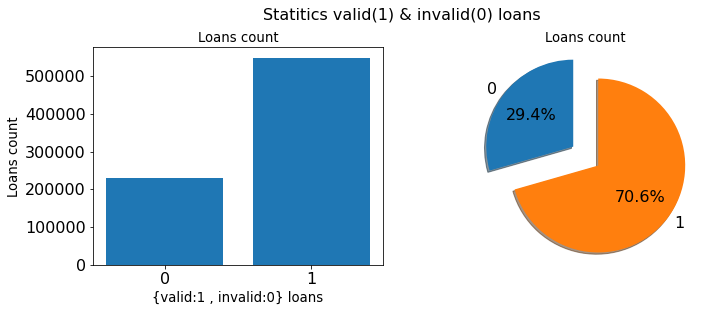

In [419]:
plotBarAndPieFromDFWithCountAndPercentage(dfJobDateValidCount, 'validStartJobDate', 
                                          name_col_pd='{valid:1 , invalid:0} loans',
                                          title='Loans count',
                                          titleFigure='Statitics valid(1) & invalid(0) loans')

# Validation loans by age

In [374]:
# age of majority for Mexico: 18 years
minAge = 18

dfAgeInvalid = dfDateDiffYeaBirMonJob.where(col('yearDiffBirth') < 18)
countDfAgeInvalid = dfAgeInvalid.count()
dfAgeInvalidPD = dfAgeInvalid.toPandas()

print(f'Number of loans wiht invalid age: {countDfAgeInvalid}')
dfAgeInvalidPD.head(6)

Number of loans wiht invalid age: 0


,id,loan_id,loan_amount,loan_date,job_start_date,birthday,monthDiffJobDec,yearDiffBirth,monthDiffJob


In [446]:
dfAgeCount = dfDateMonthJobsWithFlagPD[['yearDiffBirth','id']] \
                            .groupby('yearDiffBirth').agg(['count'])
dfAgeCount.columns = dfAgeCount.columns.droplevel(0)
dfAgeCount = dfAgeCount.sort_values(by=['yearDiffBirth'])
total_loans = sum(dfAgeCount['count'].tolist())
dfAgeCount['percentage'] = dfAgeCount['count'] / total_loans
dfAgeCount['yearDiffBirth'] = dfAgeCount.index.astype(str)
dfAgeCount.head(6)

,count,percentage,yearDiffBirth
yearDiffBirth,,,
18,20,0.000026,18
19,191,0.000246,19
20,1104,0.001420,20
21,2319,0.002982,21
22,4437,0.005705,22
23,7188,0.009242,23


/home/marchelo/anaconda3/envs/kue_mle/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator


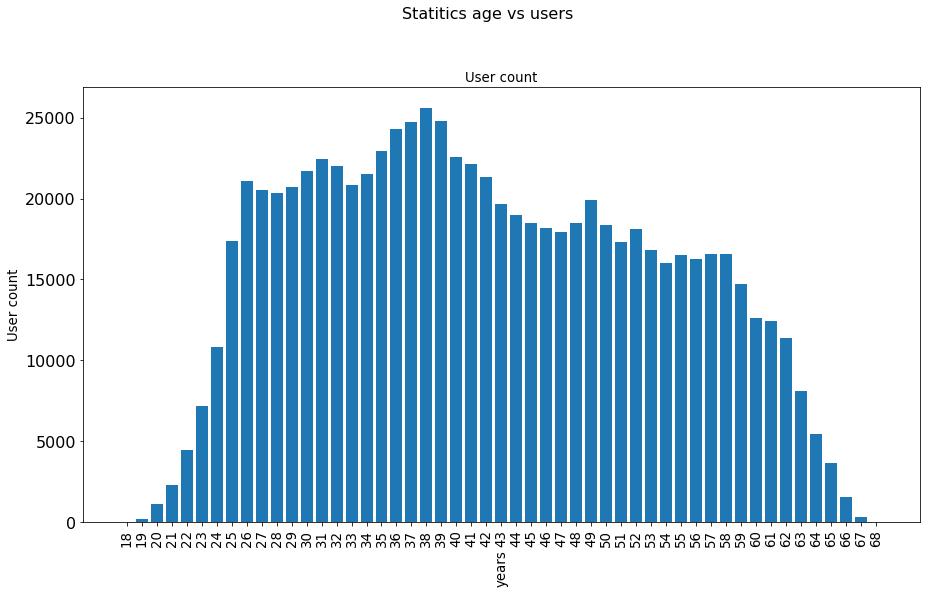

In [456]:
plotBarWithDFWithCountAndPercentage1(dfAgeCount, 'yearDiffBirth', 
                                          name_col_pd='years',
                                          title='User count',
                                          titleFigure='Statitics age vs users')
    